<a href="https://colab.research.google.com/github/fabriziobasso/Colab_backup/blob/main/brist1d_blood_glucose_prediction_tabnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BrisT1D Blood Glucose Prediction with TabNet V0

In [ ]:
%%capture
!pip install -qq pytorch_tabnet
!!pip install optuna
!pip install optuna-integration-pytorch-tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

In [ ]:
df_train.shape

(177024, 507)

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = df_train[colset].interpolate(axis=1)
    df_test[colset] = df_test[colset].interpolate(axis=1)

In [ ]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
imputer = SimpleImputer(strategy="mean")

df_train[feature_cols] = imputer.fit_transform(df_train[feature_cols])
df_test[feature_cols] = imputer.transform(df_test[feature_cols])

In [ ]:
df_train[feature_cols].isna().sum()

,0
bg-0-00,0
bg-0-05,0
bg-0-10,0
bg-0-15,0
bg-0-20,0
...,...
cals-0-35,0
cals-0-40,0
cals-0-45,0
cals-0-50,0


## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [ ]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]]

In [ ]:
df_train.isna().sum()

,0
p_num,0
time,0
bg-5-55,27254
bg-5-50,18491
bg-5-45,13660
...,...
activity-0-05,174271
activity-0-00,174287
bg+1-00,0
sin_hour,0


## Training & Inference


In [ ]:
X = df_train[feature_cols]
y = df_train[[target_col]]

In [ ]:
# X.columns

# print(feature_cols)

X.isna().sum().sum()

0

In [ ]:
X = df_train[feature_cols]
y = df_train[[target_col]]
groups = df_train[group_col]
cv = GroupKFold(5)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    reg = TabNetRegressor(
        grouped_features=grouped_features,
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v1/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].to_numpy()

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / 5
    i += 1

Fold 0
epoch 0  | loss: 6.85918 | val_0_rmse: 2.71554 |  0:00:07s
epoch 1  | loss: 4.24413 | val_0_rmse: 2.21357 |  0:00:14s


KeyboardInterrupt: 

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

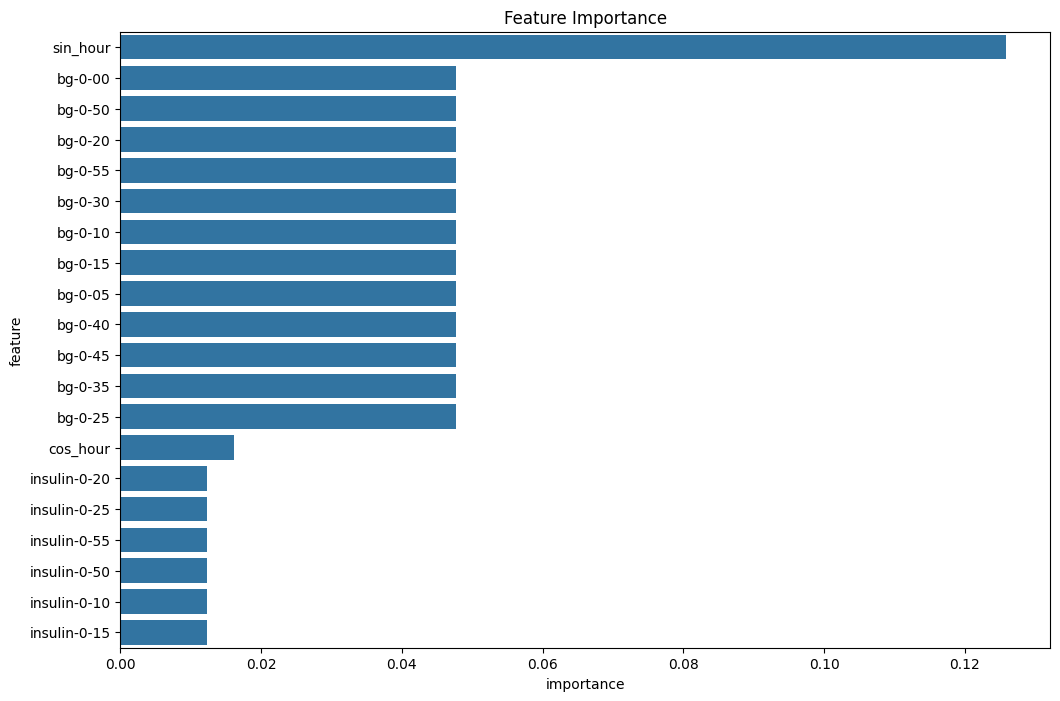

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

## Save Results:

In [ ]:
df_subm.head()

,bg+1:00
id,
p01_8459,8.972011
p01_8460,5.830921
p01_8461,7.794858
p01_8462,10.844385
p01_8463,6.398709


In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v0.csv')

In [ ]:
oof_results.head()

,0,1,2,3,4
id,,,,,
p01_0,NaN,NaN,NaN,13.334588,NaN
p01_1,NaN,NaN,NaN,12.762192,NaN
p01_2,NaN,NaN,NaN,12.50032,NaN
p01_3,NaN,NaN,NaN,12.799201,NaN
p01_4,NaN,NaN,NaN,12.184162,NaN


In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

,0,1,2,3,4,average
id,,,,,,
p01_0,NaN,NaN,NaN,13.334588,NaN,13.334588
p01_1,NaN,NaN,NaN,12.762192,NaN,12.762192
p01_2,NaN,NaN,NaN,12.50032,NaN,12.50032
p01_3,NaN,NaN,NaN,12.799201,NaN,12.799201
p01_4,NaN,NaN,NaN,12.184162,NaN,12.184162


In [ ]:
oof_results.isna().sum()

,0
0,150996
1,142864
2,143187
3,143266
4,127783
average,0


In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v0.csv")

# BrisT1D BGP with TabNet V1

In [ ]:
!pip install -qq pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['steps', 'carbs', 'activity', 'insulin', 'cals', 'hr', 'bg']

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [ ]:
from datetime import timedelta

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(10):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * new_train[date_col].dt.hour / 12)
new_train['cos_hour'] = np.cos(np.pi * new_train[date_col].dt.hour / 12)

#new_train = new_train[feature_cols]
new_train.shape

(36440, 88)

In [ ]:
df_train.shape

(177024, 507)

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [ ]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]]

In [ ]:
df_train.isna().sum()

,0
p_num,0
time,0
bg-5-55,0
bg-5-50,0
bg-5-45,0
...,...
activity-0-05,174271
activity-0-00,174287
bg+1-00,0
sin_hour,0


## Training & Inference


In [ ]:
new_train

X = df_train[feature_cols]
y = df_train[[target_col]]

In [ ]:
# X.columns

# print(feature_cols)

X.head(3)#.isna().sum().sum()

,bg-0-55,bg-0-50,bg-0-45,bg-0-40,bg-0-35,bg-0-30,bg-0-25,bg-0-20,bg-0-15,bg-0-10,...,cals-0-35,cals-0-30,cals-0-25,cals-0-20,cals-0-15,cals-0-10,cals-0-05,cals-0-00,sin_hour,cos_hour
id,,,,,,,,,,,,,,,,,,,,,
p01_0,17.5,17.5,17.5,17.433333,17.366667,17.3,16.933333,16.566667,16.2,15.833333,...,9.223469,9.22133,9.224794,9.225912,9.224258,9.22529,9.222623,9.211014,1.0,6.123234e-17
p01_1,17.3,17.3,17.3,16.933333,16.566667,16.2,15.833333,15.466667,15.1,14.866667,...,9.223469,9.22133,9.224794,9.225912,9.224258,9.22529,9.222623,9.211014,1.0,6.123234e-17
p01_2,16.2,16.2,16.2,15.833333,15.466667,15.1,14.866667,14.633333,14.4,14.233333,...,9.223469,9.22133,9.224794,9.225912,9.224258,9.22529,9.222623,9.211014,1.0,6.123234e-17


In [ ]:
new_train[feature_cols].tail(3)

,bg-0-55,bg-0-50,bg-0-45,bg-0-40,bg-0-35,bg-0-30,bg-0-25,bg-0-20,bg-0-15,bg-0-10,...,cals-0-35,cals-0-30,cals-0-25,cals-0-20,cals-0-15,cals-0-10,cals-0-05,cals-0-00,sin_hour,cos_hour
36437,10.8,10.8,10.7,10.4,10.3,10.1,10.0,9.9,9.9,9.9,...,4.15,4.15,4.15,4.15,4.15,4.15,4.15,4.15,0.500000,0.866025
36438,7.9,8.0,7.9,7.8,7.7,7.7,7.6,7.5,7.5,7.2,...,4.15,4.15,4.15,4.15,4.15,4.15,4.15,4.15,0.965926,0.258819
36439,5.9,5.9,5.9,5.9,5.8,5.5,5.5,5.4,5.4,5.7,...,4.15,4.31,4.23,9.29,4.40,4.15,4.15,4.15,0.500000,0.866025


In [ ]:
#pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)

In [ ]:
# new_train.shape,X.shape
# plt.plot(y)

In [ ]:
X = df_train[feature_cols]
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(7)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    reg = TabNetRegressor(
        grouped_features=grouped_features,
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
        max_epochs=100,
        patience=15,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v1/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].to_numpy()

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / 5
    i += 1

df_subm.to_csv('submission_tabnet.csv')

Fold 0
epoch 0  | loss: 7.13361 | val_0_rmse: 2.20941 |  0:00:09s


KeyboardInterrupt: 

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

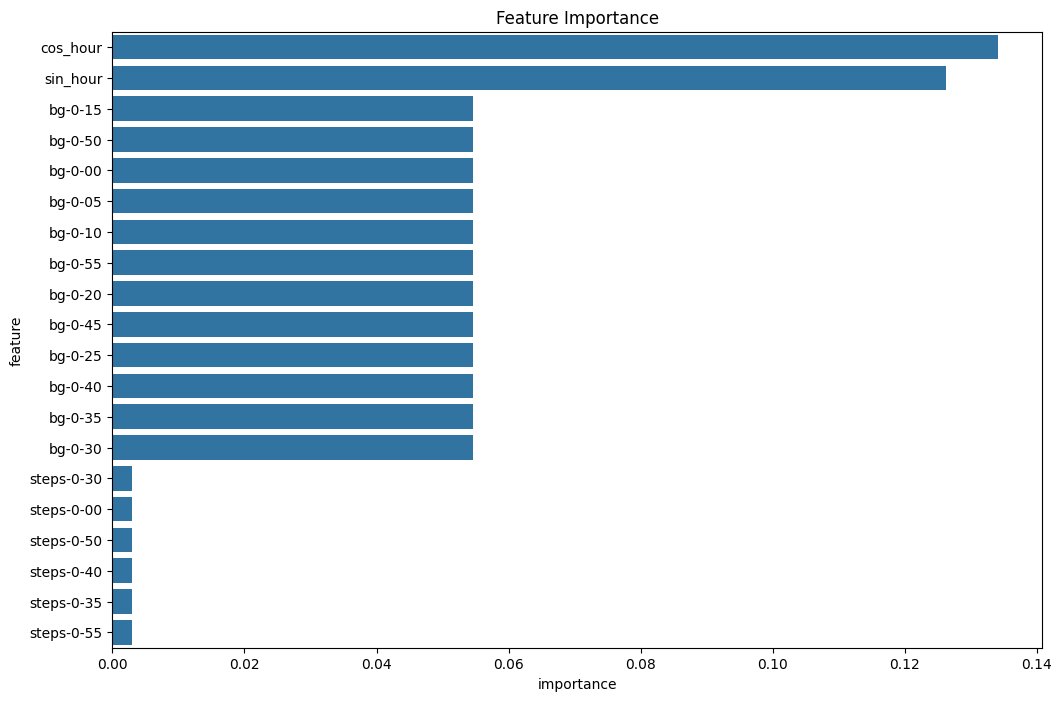

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

## Save Results:

In [ ]:
df_subm.head()

,bg+1:00
id,
p01_8459,8.631357
p01_8460,6.126371
p01_8461,7.723211
p01_8462,10.624363
p01_8463,6.908243


In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v1.csv')

In [ ]:
oof_results.head()

,0,1,2,3,4
0,NaN,NaN,11.73698,NaN,NaN
1,NaN,NaN,11.303996,NaN,NaN
2,NaN,NaN,11.140917,NaN,NaN
3,NaN,NaN,11.685648,NaN,NaN
4,NaN,NaN,11.166823,NaN,NaN


In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

,0,1,2,3,4,average
0,NaN,NaN,11.73698,NaN,NaN,11.73698
1,NaN,NaN,11.303996,NaN,NaN,11.303996
2,NaN,NaN,11.140917,NaN,NaN,11.140917
3,NaN,NaN,11.685648,NaN,NaN,11.685648
4,NaN,NaN,11.166823,NaN,NaN,11.166823


In [ ]:
oof_results.isna().sum()

,0
0,172785
1,174599
2,172939
3,172862
4,160671
average,0


In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v1.csv")

# BrisT1D BGP with TabNet V2

In [ ]:
!pip install -qq pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['hr', 'cals', 'insulin', 'carbs', 'activity', 'bg', 'steps']

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [ ]:
from datetime import timedelta

### Extract Additional Data:

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(10):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * new_train[date_col].dt.hour / 12)
new_train['cos_hour'] = np.cos(np.pi * new_train[date_col].dt.hour / 12)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

(36440, 88)

In [ ]:
df_train.shape

(177024, 507)

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [ ]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols, static, time_group]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71],
 [72],
 [73, 74]]

In [ ]:
df_train.isna().sum()

,0
p_num,0
time,0
bg-5-55,0
bg-5-50,0
bg-5-45,0
...,...
activity-0-05,174271
activity-0-00,174287
bg+1-00,0
sin_hour,0


## Training & Inference


In [ ]:
new_train

X = df_train[feature_cols]
y = df_train[[target_col]]

rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [ ]:
# X.columns

# print(feature_cols)

X.isna().sum().sum()

0

In [ ]:
X = df_train[feature_cols].copy()
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)
FOLDS = 7

X["p_num"].replace(rep_dict, inplace=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(FOLDS)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(FOLDS)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    reg = TabNetRegressor(
        grouped_features=grouped_features,
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
        max_epochs=100,
        patience=15,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v2/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].copy()
    X_test["p_num"].replace(rep_dict, inplace=True)
    X_test = X_test.to_numpy()


    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / FOLDS
    i += 1

#df_subm.to_csv('submission_tabnet.csv')

Fold 0
epoch 0  | loss: 8.13844 | val_0_rmse: 2.13293 |  0:00:10s
epoch 1  | loss: 4.63448 | val_0_rmse: 2.38744 |  0:00:20s
epoch 2  | loss: 4.53453 | val_0_rmse: 2.14449 |  0:00:31s
epoch 3  | loss: 4.44103 | val_0_rmse: 2.05799 |  0:00:41s
epoch 4  | loss: 4.40279 | val_0_rmse: 2.08979 |  0:00:51s
epoch 5  | loss: 4.3598  | val_0_rmse: 2.10855 |  0:01:01s
epoch 6  | loss: 4.3307  | val_0_rmse: 2.02228 |  0:01:12s
epoch 7  | loss: 4.30132 | val_0_rmse: 2.20839 |  0:01:23s
epoch 8  | loss: 4.28173 | val_0_rmse: 2.10069 |  0:01:34s
epoch 9  | loss: 4.26313 | val_0_rmse: 2.03755 |  0:01:44s
epoch 10 | loss: 4.23489 | val_0_rmse: 2.0477  |  0:01:55s
epoch 11 | loss: 4.22437 | val_0_rmse: 2.1466  |  0:02:05s
epoch 12 | loss: 4.19014 | val_0_rmse: 2.03621 |  0:02:16s
epoch 13 | loss: 4.16345 | val_0_rmse: 2.11344 |  0:02:26s
epoch 14 | loss: 4.14758 | val_0_rmse: 2.06566 |  0:02:37s
epoch 15 | loss: 4.11588 | val_0_rmse: 2.11265 |  0:02:48s
epoch 16 | loss: 4.13571 | val_0_rmse: 2.22966 | 

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

## Save Results:

In [ ]:
df_subm.head()

,bg+1:00
id,
p01_8459,9.007207
p01_8460,5.922358
p01_8461,8.111410
p01_8462,10.851858
p01_8463,7.251251


In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v2.csv')

In [ ]:
oof_results.head()

,0,1,2,3,4,5,6
0,NaN,NaN,NaN,NaN,NaN,NaN,14.16102
1,NaN,NaN,NaN,NaN,NaN,NaN,13.622066
2,NaN,NaN,NaN,NaN,NaN,NaN,13.333781
3,NaN,NaN,NaN,NaN,NaN,NaN,13.562715
4,NaN,NaN,NaN,NaN,NaN,NaN,13.082964


In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

,0,1,2,3,4,5,6,average
0,NaN,NaN,NaN,NaN,NaN,NaN,14.16102,14.16102
1,NaN,NaN,NaN,NaN,NaN,NaN,13.622066,13.622066
2,NaN,NaN,NaN,NaN,NaN,NaN,13.333781,13.333781
3,NaN,NaN,NaN,NaN,NaN,NaN,13.562715,13.562715
4,NaN,NaN,NaN,NaN,NaN,NaN,13.082964,13.082964


In [ ]:
oof_results.isna().sum()

,0
0,182975
1,182962
2,183738
3,183740
4,184089
5,182486
6,180794
average,0


In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v2.csv")

# BrisT1D BGP with TabNet V3&4

In [ ]:
!pip install -qq pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['steps', 'carbs', 'activity', 'insulin', 'cals', 'hr', 'bg']

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [ ]:
from datetime import timedelta

### Extract Additional Data:

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(20):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)
new_train['cos_hour'] = np.cos(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

(72880, 88)

In [ ]:
df_train.shape

(177024, 507)

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)
df_train['cos_hour'] = np.cos(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)

df_test['sin_hour'] = np.sin(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)
df_test['cos_hour'] = np.cos(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [ ]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols, static, time_group]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71],
 [72],
 [73, 74]]

## Training & Inference


In [ ]:
new_train

X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [ ]:
# X.columns

# print(feature_cols)

X.isna().sum().sum()

0

In [ ]:
X = df_train[feature_cols].copy()
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)
FOLDS = 7

X["p_num"].replace(rep_dict, inplace=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(FOLDS)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(FOLDS)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    reg = TabNetRegressor(
        grouped_features=grouped_features,
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
        max_epochs=100,
        patience=15,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v4/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].copy()
    X_test["p_num"].replace(rep_dict, inplace=True)
    X_test = X_test.to_numpy()


    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / FOLDS
    i += 1

#df_subm.to_csv('submission_tabnet.csv')

Fold 0
epoch 0  | loss: 7.66855 | val_0_rmse: 2.13405 |  0:00:10s
epoch 1  | loss: 4.64557 | val_0_rmse: 2.08696 |  0:00:20s
epoch 2  | loss: 4.56179 | val_0_rmse: 2.06094 |  0:00:30s
epoch 3  | loss: 4.53967 | val_0_rmse: 2.04054 |  0:00:40s
epoch 4  | loss: 4.50344 | val_0_rmse: 1.99638 |  0:00:50s
epoch 5  | loss: 4.46169 | val_0_rmse: 2.01852 |  0:00:59s
epoch 6  | loss: 4.44673 | val_0_rmse: 2.13648 |  0:01:09s
epoch 7  | loss: 4.43144 | val_0_rmse: 2.03962 |  0:01:19s
epoch 8  | loss: 4.39539 | val_0_rmse: 2.04892 |  0:01:29s
epoch 9  | loss: 4.39543 | val_0_rmse: 2.04222 |  0:01:39s
epoch 10 | loss: 4.37592 | val_0_rmse: 2.0335  |  0:01:49s
epoch 11 | loss: 4.32558 | val_0_rmse: 2.12712 |  0:01:58s
epoch 12 | loss: 4.31204 | val_0_rmse: 2.08309 |  0:02:08s
epoch 13 | loss: 4.31422 | val_0_rmse: 2.10352 |  0:02:18s
epoch 14 | loss: 4.33325 | val_0_rmse: 2.09315 |  0:02:28s
epoch 15 | loss: 4.28492 | val_0_rmse: 2.04128 |  0:02:38s
epoch 16 | loss: 4.2945  | val_0_rmse: 2.04481 | 

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

### Model Hyperparameter Tuning:

In [ ]:
df_train.reset_index(inplace=True, drop=True)

In [ ]:
import optuna
from sklearn.metrics import mean_squared_error

X = df_train[feature_cols].copy()
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)

X["p_num"].replace(rep_dict, inplace=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

def objective(trial,FOLDS=3):
    """
    Objective function for Optuna to optimize TabNetRegressor hyperparameters.

    Args:
        trial: Optuna trial object.
        X: Feature matrix.
        y: Target variable.
        n_splits: Number of cross-validation splits.

    Returns:
        float: Mean cross-validated RMSE.
    """

    # Suggest hyperparameters using Optuna's trial object
    params = {
        "n_d": trial.suggest_int("n_d", 8, 16, step=2),
        "n_a": trial.suggest_int("n_a", 8, 16, step=2),
        "n_steps": trial.suggest_int("n_steps", 3, 5),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True),
        "verbose": 0,  # Suppress verbose output during optimization
    }

    # K-fold cross-validation
    kf = GroupKFold(FOLDS)
    rmse_scores = []

    for train_index, val_index in kf.split(X, y, groups=groups):
        X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
        X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

        # Create and train the TabNet model
        model = TabNetRegressor(grouped_features=grouped_features, **params)
        model.fit(
            X_train=X_train,
            y_train=y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric=["rmse"],
            max_epochs=15,  # You might need to adjust this
            patience=5,  # Early stopping patience
        )

        # Make predictions and evaluate
        y_pred = model.predict(X_valid)
        rmse = mean_squared_error(y_valid, y_pred, squared=False)
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)  # Return the mean RMSE across folds


# --- Example usage ---
# Assuming you have your data loaded as X and y (NumPy arrays or Pandas DataFrames)

# Create an Optuna study
study = optuna.create_study(direction="minimize", study_name="tabnet_tuning")

# Optimize the objective function
study.optimize(lambda trial: objective(trial), n_trials=100)  # Adjust n_trials

# Get the best parameters and results
best_params = study.best_params
best_rmse = study.best_value

print(f"Best RMSE: {best_rmse:.4f}")
print("Best hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

[I 2024-11-25 22:46:21,466] A new study created in memory with name: tabnet_tuning



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.45957

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.45957

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.45957


[I 2024-11-25 22:52:02,332] Trial 0 finished with value: 2.459570272548515 and parameters: {'n_d': 12, 'n_a': 16, 'n_steps': 3, 'gamma': 1.3490784113575338, 'lambda_sparse': 8.471568555451309e-05}. Best is trial 0 with value: 2.459570272548515.



Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.41209

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.41209

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.41209


[I 2024-11-25 22:56:57,168] Trial 1 finished with value: 2.4120854038520774 and parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.3041222166061175, 'lambda_sparse': 3.957685023182555e-05}. Best is trial 1 with value: 2.4120854038520774.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_rmse = 2.39257

Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_rmse = 2.39257

Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_rmse = 2.39257


[I 2024-11-25 23:07:53,770] Trial 2 finished with value: 2.392569259528497 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.7445943523450596, 'lambda_sparse': 0.006331983758155842}. Best is trial 2 with value: 2.392569259528497.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_rmse = 2.39149

Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_rmse = 2.39149

Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_rmse = 2.39149


[I 2024-11-25 23:16:54,938] Trial 3 finished with value: 2.391493871510805 and parameters: {'n_d': 12, 'n_a': 10, 'n_steps': 3, 'gamma': 1.3760921662808248, 'lambda_sparse': 0.0015459917383043482}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.39254

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.39254

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.39254


[I 2024-11-25 23:25:21,099] Trial 4 finished with value: 2.392541915969973 and parameters: {'n_d': 10, 'n_a': 12, 'n_steps': 5, 'gamma': 1.6501876075101474, 'lambda_sparse': 0.0004364114571650071}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_rmse = 2.45072

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_rmse = 2.45072

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_rmse = 2.45072


[I 2024-11-25 23:30:55,705] Trial 5 finished with value: 2.450718169171711 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 4, 'gamma': 1.2693171006163841, 'lambda_sparse': 5.415085169273254e-05}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.47671

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.47671

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.47671


[I 2024-11-25 23:35:55,197] Trial 6 finished with value: 2.476707663252563 and parameters: {'n_d': 14, 'n_a': 10, 'n_steps': 3, 'gamma': 1.324547021628604, 'lambda_sparse': 4.4140005941474256e-05}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.43115

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.43115

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.43115


[I 2024-11-25 23:46:38,729] Trial 7 finished with value: 2.43114977088551 and parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.6665271706474591, 'lambda_sparse': 0.008379302367947563}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.39588

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.39588

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.39588


[I 2024-11-25 23:57:09,759] Trial 8 finished with value: 2.395875326379685 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 4, 'gamma': 1.4043390302148786, 'lambda_sparse': 7.579749177032064e-05}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_rmse = 2.42878

Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_rmse = 2.42878

Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_rmse = 2.42878


[I 2024-11-26 00:05:16,423] Trial 9 finished with value: 2.4287805008465173 and parameters: {'n_d': 10, 'n_a': 14, 'n_steps': 4, 'gamma': 1.826027275212689, 'lambda_sparse': 7.054854384682835e-05}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_0_rmse = 2.3977


[W 2024-11-26 00:08:58,300] Trial 10 failed with parameters: {'n_d': 12, 'n_a': 12, 'n_steps': 3, 'gamma': 1.0087237559084916, 'lambda_sparse': 0.0007123742377882674} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-250-fc6b05ef4915>", line 73, in <lambda>
    study.optimize(lambda trial: objective(trial), n_trials=100)  # Adjust n_trials
  File "<ipython-input-250-fc6b05ef4915>", line 49, in objective
    model.fit(
  File "/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py", line 258, in fit
    self._train_epoch(train_dataloader)
  File "/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py", line 489, in _train_epoch
    batch_logs = self._train_batch(X, y)
  File "/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py", line 534, 

KeyboardInterrupt: 

## Save Results:

In [ ]:
df_subm.head()

,bg+1:00
id,
p01_8459,8.682322
p01_8460,6.385798
p01_8461,7.867571
p01_8462,10.428039
p01_8463,6.939459


In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v4.csv')

In [ ]:
oof_results.head()

,0,1,2,3,4,5,6
0,NaN,NaN,NaN,NaN,NaN,NaN,11.174798
1,NaN,NaN,NaN,NaN,NaN,NaN,10.628863
2,NaN,NaN,NaN,NaN,NaN,NaN,10.553446
3,NaN,NaN,NaN,NaN,NaN,NaN,11.087376
4,NaN,NaN,NaN,NaN,NaN,NaN,10.675967


In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

,0,1,2,3,4,5,6,average
0,NaN,NaN,NaN,NaN,NaN,NaN,11.174798,11.174798
1,NaN,NaN,NaN,NaN,NaN,NaN,10.628863,10.628863
2,NaN,NaN,NaN,NaN,NaN,NaN,10.553446,10.553446
3,NaN,NaN,NaN,NaN,NaN,NaN,11.087376,11.087376
4,NaN,NaN,NaN,NaN,NaN,NaN,10.675967,10.675967


In [ ]:
oof_results.isna().sum()

,0
0,214225
1,214772
2,215138
3,215910
4,215709
5,210813
6,212857
average,0


In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v4.csv")

# BrisT1D Blood Glucose Prediction with TabNet V5

In [ ]:
!pip install -qq pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['activity', 'bg', 'hr', 'steps', 'carbs', 'cals', 'insulin']

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [ ]:
from datetime import timedelta

### Extract Additional Data:

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(20):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train['sin_hour'] = np.sin(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)
new_train['cos_hour'] = np.cos(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

(72880, 88)

In [ ]:
df_train.shape

(177024, 507)

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)
df_train['cos_hour'] = np.cos(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)

df_test['sin_hour'] = np.sin(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)
df_test['cos_hour'] = np.cos(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [ ]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols, static, time_group]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71],
 [72],
 [73, 74]]

## Training & Inference


In [ ]:
new_train

X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [ ]:
# X.columns

# print(feature_cols)

X_.isna().sum().sum()

0

In [ ]:
X = df_train[feature_cols].copy()
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)
FOLDS = 5

X["p_num"].replace(rep_dict, inplace=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(FOLDS)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(FOLDS)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    params = {'n_d': 12, 'n_a': 10, 'n_steps': 3, 'gamma': 1.3760921662808248, 'lambda_sparse': 0.0015459917383043482}
    reg = TabNetRegressor(
        grouped_features=grouped_features,**params
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
        max_epochs=100,
        patience=15,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v5/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].copy()
    X_test["p_num"].replace(rep_dict, inplace=True)
    X_test = X_test.to_numpy()


    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / FOLDS
    i += 1

#df_subm.to_csv('submission_tabnet.csv')

Fold 0
epoch 0  | loss: 6.99283 | val_0_rmse: 2.32993 |  0:00:11s
epoch 1  | loss: 4.87637 | val_0_rmse: 1.97313 |  0:00:22s
epoch 2  | loss: 4.75718 | val_0_rmse: 1.91931 |  0:00:34s
epoch 3  | loss: 4.67518 | val_0_rmse: 1.94227 |  0:00:46s
epoch 4  | loss: 4.62563 | val_0_rmse: 1.95755 |  0:00:57s
epoch 5  | loss: 4.59259 | val_0_rmse: 1.95134 |  0:01:08s
epoch 6  | loss: 4.56158 | val_0_rmse: 1.94352 |  0:01:20s
epoch 7  | loss: 4.50437 | val_0_rmse: 1.94084 |  0:01:31s
epoch 8  | loss: 4.46688 | val_0_rmse: 1.88115 |  0:01:43s
epoch 9  | loss: 4.46595 | val_0_rmse: 1.89906 |  0:01:54s
epoch 10 | loss: 4.43242 | val_0_rmse: 1.94646 |  0:02:06s
epoch 11 | loss: 4.42978 | val_0_rmse: 1.89381 |  0:02:18s
epoch 12 | loss: 4.4066  | val_0_rmse: 1.9095  |  0:02:30s
epoch 13 | loss: 4.38362 | val_0_rmse: 1.91272 |  0:02:41s
epoch 14 | loss: 4.37424 | val_0_rmse: 1.96476 |  0:02:53s
epoch 15 | loss: 4.37419 | val_0_rmse: 1.88153 |  0:03:04s
epoch 16 | loss: 4.36567 | val_0_rmse: 1.98891 | 

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

NameError: name 'pd' is not defined

### Model Hyperparameter Tuning:

In [ ]:
# df_train.reset_index(inplace=True, drop=True)

In [ ]:
# import optuna
# from sklearn.metrics import mean_squared_error

# X = df_train[feature_cols].copy()
# X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
# y = df_train[[target_col]]
# y = pd.concat([y, new_target], axis=0, ignore_index=True)

# X["p_num"].replace(rep_dict, inplace=True)

# groups_0 = df_train[group_col]
# groups_1 = new_train[group_col]
# groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

# def objective(trial,FOLDS=3):
#     """
#     Objective function for Optuna to optimize TabNetRegressor hyperparameters.

#     Args:
#         trial: Optuna trial object.
#         X: Feature matrix.
#         y: Target variable.
#         n_splits: Number of cross-validation splits.

#     Returns:
#         float: Mean cross-validated RMSE.
#     """

#     # Suggest hyperparameters using Optuna's trial object
#     params = {
#         "n_d": trial.suggest_int("n_d", 8, 16, step=2),
#         "n_a": trial.suggest_int("n_a", 8, 16, step=2),
#         "n_steps": trial.suggest_int("n_steps", 3, 5),
#         "gamma": trial.suggest_float("gamma", 1.0, 2.0),
#         "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True),
#         "verbose": 0,  # Suppress verbose output during optimization
#     }

#     # K-fold cross-validation
#     kf = GroupKFold(FOLDS)
#     rmse_scores = []

#     for train_index, val_index in kf.split(X, y, groups=groups):
#         X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
#         X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

#         # Create and train the TabNet model
#         model = TabNetRegressor(grouped_features=grouped_features, **params)
#         model.fit(
#             X_train=X_train,
#             y_train=y_train,
#             eval_set=[(X_valid, y_valid)],
#             eval_metric=["rmse"],
#             max_epochs=15,  # You might need to adjust this
#             patience=5,  # Early stopping patience
#         )

#         # Make predictions and evaluate
#         y_pred = model.predict(X_valid)
#         rmse = mean_squared_error(y_valid, y_pred, squared=False)
#         rmse_scores.append(rmse)

#     return np.mean(rmse_scores)  # Return the mean RMSE across folds


# # --- Example usage ---
# # Assuming you have your data loaded as X and y (NumPy arrays or Pandas DataFrames)

# # Create an Optuna study
# study = optuna.create_study(direction="minimize", study_name="tabnet_tuning")

# # Optimize the objective function
# study.optimize(lambda trial: objective(trial), n_trials=100)  # Adjust n_trials

# # Get the best parameters and results
# best_params = study.best_params
# best_rmse = study.best_value

# print(f"Best RMSE: {best_rmse:.4f}")
# print("Best hyperparameters:")
# for key, value in best_params.items():
#     print(f"  {key}: {value}")

## Save Results:

In [ ]:
df_subm.head()

,bg+1:00
id,
p01_8459,8.480623
p01_8460,6.460919
p01_8461,8.065517
p01_8462,10.614953
p01_8463,6.733258


In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v5.csv')

In [ ]:
oof_results.head()

,0,1,2,3,4
0,NaN,NaN,12.240019,NaN,NaN
1,NaN,NaN,11.708904,NaN,NaN
2,NaN,NaN,11.55581,NaN,NaN
3,NaN,NaN,11.908131,NaN,NaN
4,NaN,NaN,11.418094,NaN,NaN


In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

,0,1,2,3,4,average
0,NaN,NaN,12.240019,NaN,NaN,12.240019
1,NaN,NaN,11.708904,NaN,NaN,11.708904
2,NaN,NaN,11.55581,NaN,NaN,11.55581
3,NaN,NaN,11.908131,NaN,NaN,11.908131
4,NaN,NaN,11.418094,NaN,NaN,11.418094


In [ ]:
oof_results.isna().sum()

,0
0,198765
1,201809
2,201999
3,202142
4,194901
average,0


In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v5.csv")

# BrisT1D BGP with TabNet V6

In [ ]:
!pip install -qq pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
activity_cols = [f'activity-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static + activity_cols

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


### Fill Activity:

In [ ]:
list_act = df_train.filter(regex="activity").columns.to_list()

act_to_replace = {"Indoor climbing":1,
                  "Run":3,
                  "Strength training":3,
                  "Swim":3,
                  "Bike":3,
                  "Dancing":2,
                  "Stairclimber":2,
                  "Spinning":3,
                  "Walking":2,
                  "HIIT":3,
                  "Cycling":3,
                  "Outdoor Bike":3,
                  "CoreTraining":3,
                  "Walk":2,
                  "Aerobic Workout":3,
                  "Tennis":2,
                  "Workout":3,
                  "Hike":2,
                  "Zumba":2,
                  "Sport":2,
                  "Yoga":1,
                  "Swimming":3,
                  "Weights":3,
                  "Running":3}


df_train.replace(act_to_replace, inplace=True)
df_train[list_act] = df_train[list_act].fillna(0).values

df_test.replace(act_to_replace, inplace=True)
df_test[list_act] = df_test[list_act].fillna(0).values

df_train[list_act] = df_train[list_act].astype(np.float32).values
df_test[list_act] = df_test[list_act].astype(np.float32).values

df_train[list_act].isna().sum().sum(), df_test[activity_cols].isna().sum().sum()

(0, 0)

In [ ]:
thisset = set()

for col in list_act:
  for act in df_train[col].unique():
    thisset.add(act)
  for act in df_test[col].unique():
    thisset.add(act)

thisset

{0.0, 1.0, 2.0, 3.0}

### All the rest

In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['activity', 'bg', 'hr', 'steps', 'carbs', 'cals', 'insulin']

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [ ]:
from datetime import timedelta

### Extract Additional Data:

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(20):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train['sin_hour'] = np.sin(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)
new_train['cos_hour'] = np.cos(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

(72880, 88)

In [ ]:
df_train.shape

(177024, 507)

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)
df_train['cos_hour'] = np.cos(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)

df_test['sin_hour'] = np.sin(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)
df_test['cos_hour'] = np.cos(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [ ]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols, activity_cols, static, time_group]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71],
 [73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84],
 [72],
 [85, 86]]

## Training & Inference


In [ ]:
new_train

X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [ ]:
# X.columns

# print(feature_cols)

X_.isna().sum().sum()

0

In [ ]:
X = df_train[feature_cols].copy()
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)
FOLDS = 5

X["p_num"].replace(rep_dict, inplace=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(FOLDS)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(FOLDS)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    params = {'n_d': 12, 'n_a': 10, 'n_steps': 3, 'gamma': 1.3760921662808248, 'lambda_sparse': 0.0015459917383043482}
    reg = TabNetRegressor(
        grouped_features=grouped_features,**params
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
        max_epochs=100,
        patience=15,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v6/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].copy()
    X_test["p_num"].replace(rep_dict, inplace=True)
    X_test = X_test.to_numpy()


    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / FOLDS
    i += 1

#df_subm.to_csv('submission_tabnet.csv')

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

### Model Hyperparameter Tuning:

In [ ]:
# df_train.reset_index(inplace=True, drop=True)

In [ ]:
# import optuna
# from sklearn.metrics import mean_squared_error

# X = df_train[feature_cols].copy()
# X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
# y = df_train[[target_col]]
# y = pd.concat([y, new_target], axis=0, ignore_index=True)

# X["p_num"].replace(rep_dict, inplace=True)

# groups_0 = df_train[group_col]
# groups_1 = new_train[group_col]
# groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

# def objective(trial,FOLDS=3):
#     """
#     Objective function for Optuna to optimize TabNetRegressor hyperparameters.

#     Args:
#         trial: Optuna trial object.
#         X: Feature matrix.
#         y: Target variable.
#         n_splits: Number of cross-validation splits.

#     Returns:
#         float: Mean cross-validated RMSE.
#     """

#     # Suggest hyperparameters using Optuna's trial object
#     params = {
#         "n_d": trial.suggest_int("n_d", 8, 16, step=2),
#         "n_a": trial.suggest_int("n_a", 8, 16, step=2),
#         "n_steps": trial.suggest_int("n_steps", 3, 5),
#         "gamma": trial.suggest_float("gamma", 1.0, 2.0),
#         "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True),
#         "verbose": 0,  # Suppress verbose output during optimization
#     }

#     # K-fold cross-validation
#     kf = GroupKFold(FOLDS)
#     rmse_scores = []

#     for train_index, val_index in kf.split(X, y, groups=groups):
#         X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
#         X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

#         # Create and train the TabNet model
#         model = TabNetRegressor(grouped_features=grouped_features, **params)
#         model.fit(
#             X_train=X_train,
#             y_train=y_train,
#             eval_set=[(X_valid, y_valid)],
#             eval_metric=["rmse"],
#             max_epochs=15,  # You might need to adjust this
#             patience=5,  # Early stopping patience
#         )

#         # Make predictions and evaluate
#         y_pred = model.predict(X_valid)
#         rmse = mean_squared_error(y_valid, y_pred, squared=False)
#         rmse_scores.append(rmse)

#     return np.mean(rmse_scores)  # Return the mean RMSE across folds


# # --- Example usage ---
# # Assuming you have your data loaded as X and y (NumPy arrays or Pandas DataFrames)

# # Create an Optuna study
# study = optuna.create_study(direction="minimize", study_name="tabnet_tuning")

# # Optimize the objective function
# study.optimize(lambda trial: objective(trial), n_trials=100)  # Adjust n_trials

# # Get the best parameters and results
# best_params = study.best_params
# best_rmse = study.best_value

# print(f"Best RMSE: {best_rmse:.4f}")
# print("Best hyperparameters:")
# for key, value in best_params.items():
#     print(f"  {key}: {value}")

## Save Results:

In [ ]:
df_subm.head()

,bg+1:00
id,
p01_8459,8.691166
p01_8460,5.699505
p01_8461,7.843000
p01_8462,10.550740
p01_8463,7.004242


In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v6.csv')

In [ ]:
oof_results.head()

,0,1,2,3,4
0,NaN,NaN,11.767273,NaN,NaN
1,NaN,NaN,11.44039,NaN,NaN
2,NaN,NaN,11.119031,NaN,NaN
3,NaN,NaN,11.430658,NaN,NaN
4,NaN,NaN,10.87448,NaN,NaN


In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

,0,1,2,3,4,average
0,NaN,NaN,11.767273,NaN,NaN,11.767273
1,NaN,NaN,11.44039,NaN,NaN,11.44039
2,NaN,NaN,11.119031,NaN,NaN,11.119031
3,NaN,NaN,11.430658,NaN,NaN,11.430658
4,NaN,NaN,10.87448,NaN,NaN,10.87448


In [ ]:
oof_results.isna().sum()

,0
0,198765
1,201809
2,201999
3,202142
4,194901
average,0


In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v6.csv")

# BrisT1D BGP with Conv2D-GRU V0

In [ ]:
!pip install -qq pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
from tqdm import tqdm
from itertools import product
from datetime import timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error


import tensorflow as tf
from keras.utils import plot_model
import tensorflow.keras.backend as K

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.__version__

'2.5.1+cu121'

## Data Variables


<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '_')
df_train.columns = df_train.columns.str.replace('-', '_')
df_test.columns = df_test.columns.str.replace(':', '_')
df_test.columns = df_test.columns.str.replace('-', '_')

In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

train_cols=df_train.columns.tolist()
# We only need the last 12 time intervals (1 hour)
bg_cols   = [col for col in train_cols if "bg_" in col ][-24:]
insu_cols = [col for col in train_cols if "insulin_" in col ][-24:]
carb_cols = [col for col in train_cols if "carbs_" in col ][-24:]
hr_cols   = [col for col in train_cols if "hr_" in col ][-24:]
step_cols = [col for col in train_cols if "steps_" in col ][-24:]
cals_cols = [col for col in train_cols if "cals_" in col ][-24:]
actv_cols = [col for col in train_cols if "activity_" in col ][-24:]

static = [group_col]

print(len(bg_cols),len(insu_cols),len(carb_cols),len(hr_cols),len(step_cols),len(cals_cols), len(actv_cols), len(static))
feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static + actv_cols

NameError: name 'df_train' is not defined

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


### Fill Activity:

In [ ]:
list_act = df_train.filter(regex="activity").columns.to_list()

act_to_replace = {"Indoor climbing":1,
                  "Run":3,
                  "Strength training":3,
                  "Swim":3,
                  "Bike":3,
                  "Dancing":2,
                  "Stairclimber":2,
                  "Spinning":3,
                  "Walking":2,
                  "HIIT":3,
                  "Cycling":3,
                  "Outdoor Bike":3,
                  "CoreTraining":3,
                  "Walk":2,
                  "Aerobic Workout":3,
                  "Tennis":2,
                  "Workout":3,
                  "Hike":2,
                  "Zumba":2,
                  "Sport":2,
                  "Yoga":1,
                  "Swimming":3,
                  "Weights":3,
                  "Running":3}


df_train.replace(act_to_replace, inplace=True)
df_train[list_act] = df_train[list_act].fillna(0).values

df_test.replace(act_to_replace, inplace=True)
df_test[list_act] = df_test[list_act].fillna(0).values

df_train[list_act] = df_train[list_act].astype(np.float32).values
df_test[list_act] = df_test[list_act].astype(np.float32).values

df_train[list_act].isna().sum().sum(), df_test[activity_cols].isna().sum().sum()

(0, 0)

In [ ]:
thisset = set()

for col in list_act:
  for act in df_train[col].unique():
    thisset.add(act)
  for act in df_test[col].unique():
    thisset.add(act)

thisset

{0.0, 1.0, 2.0, 3.0}

### All the rest

In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['activity', 'bg', 'hr', 'steps', 'carbs', 'cals', 'insulin']

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [ ]:
#Scale features
df_tmp=pd.concat([train,test])
scaler = MinMaxScaler(feature_range=(0,1))
df_tmp[feature_cols]=scaler.fit_transform(df_tmp[feature_cols])

train=df_tmp[:len(train)]
test=df_tmp[len(train):]
del df_tmp
gc.collect()

### Extract Additional Data:

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(20):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train['sin_hour'] = np.sin(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)
new_train['cos_hour'] = np.cos(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

(72880, 88)

In [ ]:
df_train.shape

(177024, 507)

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)
df_train['cos_hour'] = np.cos(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)

df_test['sin_hour'] = np.sin(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)
df_test['cos_hour'] = np.cos(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [ ]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols, activity_cols, static, time_group]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71],
 [73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84],
 [72],
 [85, 86]]

## Training & Inference


In [ ]:
new_train

X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [ ]:
# X.columns

# print(feature_cols)

X_.isna().sum().sum()

0

In [ ]:
X = df_train[feature_cols].copy()
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)
FOLDS = 5

X["p_num"].replace(rep_dict, inplace=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(FOLDS)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(FOLDS)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    params = {'n_d': 12, 'n_a': 10, 'n_steps': 3, 'gamma': 1.3760921662808248, 'lambda_sparse': 0.0015459917383043482}
    reg = TabNetRegressor(
        grouped_features=grouped_features,**params
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
        max_epochs=100,
        patience=15,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v6/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].copy()
    X_test["p_num"].replace(rep_dict, inplace=True)
    X_test = X_test.to_numpy()


    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / FOLDS
    i += 1

#df_subm.to_csv('submission_tabnet.csv')

Fold 0
epoch 0  | loss: 7.46061 | val_0_rmse: 2.09166 |  0:00:13s
epoch 1  | loss: 4.90793 | val_0_rmse: 1.88767 |  0:00:26s
epoch 2  | loss: 4.78243 | val_0_rmse: 1.88556 |  0:00:38s
epoch 3  | loss: 4.65725 | val_0_rmse: 1.92093 |  0:00:50s
epoch 4  | loss: 4.6236  | val_0_rmse: 1.89921 |  0:01:03s
epoch 5  | loss: 4.56283 | val_0_rmse: 1.93433 |  0:01:15s
epoch 6  | loss: 4.53764 | val_0_rmse: 1.9519  |  0:01:28s
epoch 7  | loss: 4.49627 | val_0_rmse: 2.06179 |  0:01:40s
epoch 8  | loss: 4.45785 | val_0_rmse: 2.05387 |  0:01:53s
epoch 9  | loss: 4.43181 | val_0_rmse: 2.13274 |  0:02:06s
epoch 10 | loss: 4.40105 | val_0_rmse: 2.22757 |  0:02:19s
epoch 11 | loss: 4.37212 | val_0_rmse: 2.12465 |  0:02:31s
epoch 12 | loss: 4.34235 | val_0_rmse: 2.14974 |  0:02:44s
epoch 13 | loss: 4.31501 | val_0_rmse: 2.15022 |  0:02:57s
epoch 14 | loss: 4.29766 | val_0_rmse: 2.07108 |  0:03:10s
epoch 15 | loss: 4.27242 | val_0_rmse: 2.12752 |  0:03:23s
epoch 16 | loss: 4.26998 | val_0_rmse: 2.21606 | 

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

### Model Hyperparameter Tuning:

In [ ]:
# df_train.reset_index(inplace=True, drop=True)

In [ ]:
# import optuna
# from sklearn.metrics import mean_squared_error

# X = df_train[feature_cols].copy()
# X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
# y = df_train[[target_col]]
# y = pd.concat([y, new_target], axis=0, ignore_index=True)

# X["p_num"].replace(rep_dict, inplace=True)

# groups_0 = df_train[group_col]
# groups_1 = new_train[group_col]
# groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

# def objective(trial,FOLDS=3):
#     """
#     Objective function for Optuna to optimize TabNetRegressor hyperparameters.

#     Args:
#         trial: Optuna trial object.
#         X: Feature matrix.
#         y: Target variable.
#         n_splits: Number of cross-validation splits.

#     Returns:
#         float: Mean cross-validated RMSE.
#     """

#     # Suggest hyperparameters using Optuna's trial object
#     params = {
#         "n_d": trial.suggest_int("n_d", 8, 16, step=2),
#         "n_a": trial.suggest_int("n_a", 8, 16, step=2),
#         "n_steps": trial.suggest_int("n_steps", 3, 5),
#         "gamma": trial.suggest_float("gamma", 1.0, 2.0),
#         "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True),
#         "verbose": 0,  # Suppress verbose output during optimization
#     }

#     # K-fold cross-validation
#     kf = GroupKFold(FOLDS)
#     rmse_scores = []

#     for train_index, val_index in kf.split(X, y, groups=groups):
#         X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
#         X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

#         # Create and train the TabNet model
#         model = TabNetRegressor(grouped_features=grouped_features, **params)
#         model.fit(
#             X_train=X_train,
#             y_train=y_train,
#             eval_set=[(X_valid, y_valid)],
#             eval_metric=["rmse"],
#             max_epochs=15,  # You might need to adjust this
#             patience=5,  # Early stopping patience
#         )

#         # Make predictions and evaluate
#         y_pred = model.predict(X_valid)
#         rmse = mean_squared_error(y_valid, y_pred, squared=False)
#         rmse_scores.append(rmse)

#     return np.mean(rmse_scores)  # Return the mean RMSE across folds


# # --- Example usage ---
# # Assuming you have your data loaded as X and y (NumPy arrays or Pandas DataFrames)

# # Create an Optuna study
# study = optuna.create_study(direction="minimize", study_name="tabnet_tuning")

# # Optimize the objective function
# study.optimize(lambda trial: objective(trial), n_trials=100)  # Adjust n_trials

# # Get the best parameters and results
# best_params = study.best_params
# best_rmse = study.best_value

# print(f"Best RMSE: {best_rmse:.4f}")
# print("Best hyperparameters:")
# for key, value in best_params.items():
#     print(f"  {key}: {value}")

## Save Results:

In [ ]:
df_subm.head()

,bg+1:00
id,
p01_8459,8.691166
p01_8460,5.699505
p01_8461,7.843000
p01_8462,10.550740
p01_8463,7.004242


In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v6.csv')

In [ ]:
oof_results.head()

,0,1,2,3,4
0,NaN,NaN,11.767273,NaN,NaN
1,NaN,NaN,11.44039,NaN,NaN
2,NaN,NaN,11.119031,NaN,NaN
3,NaN,NaN,11.430658,NaN,NaN
4,NaN,NaN,10.87448,NaN,NaN


In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

,0,1,2,3,4,average
0,NaN,NaN,11.767273,NaN,NaN,11.767273
1,NaN,NaN,11.44039,NaN,NaN,11.44039
2,NaN,NaN,11.119031,NaN,NaN,11.119031
3,NaN,NaN,11.430658,NaN,NaN,11.430658
4,NaN,NaN,10.87448,NaN,NaN,10.87448


In [ ]:
oof_results.isna().sum()

,0
0,198765
1,201809
2,201999
3,202142
4,194901
average,0


In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v6.csv")

# BrisT1D BGP with StackedRegressor V0

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer, KNNImputer
import warnings

# Import necessary libraries
from sklearn.linear_model import Ridge  # Meta-learner
from sklearn.ensemble import StackingRegressor
warnings.filterwarnings("ignore")

In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = "bg+1-00"  # Target column name for prediction
group_col = "p_num"  # Column name for grouping (e.g., participant number)
date_col = "time"  # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols = [f"bg-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
insu_cols = [f"insulin-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
carb_cols = [f"carbs-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
hr_cols = [f"hr-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
step_cols = [f"steps-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
cals_cols = [f"cals-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols

In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

In [ ]:
import random
import os
import numpy as np
import torch


def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
seed = 43  #
Thr_NAN = 49
seed_everything(seed)

In [ ]:
# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(":", "-")
df_test.columns = df_test.columns.str.replace(":", "-")


for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="bfill", axis=1)
        .fillna(method="ffill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="bfill", axis=1)
        .fillna(method="ffill", axis=1)
    )

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['activity', 'bg', 'hr', 'steps', 'carbs', 'cals', 'insulin']

In [ ]:
#mask = df_train[feature_cols].isna().sum(axis=1) <= Thr_NAN
# Apply the mask to filter the rows
#df_train = df_train[mask]

imputer = SimpleImputer()

df_train[feature_cols] = imputer.fit_transform(df_train[feature_cols])
df_test[feature_cols] = imputer.transform(df_test[feature_cols])

In [ ]:
df_train.shape

(177024, 507)

In [ ]:
df_train["sin_hour"] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train["cos_hour"] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test["sin_hour"] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test["cos_hour"] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(["sin_hour", "cos_hour"])


grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)


df_train_final = df_train[feature_cols]
groups = df_train[group_col]

y_target = df_train[[target_col]]

df_test_final = df_test[feature_cols]

In [ ]:
df_train_final.columns

Index(['bg-0-00', 'bg-0-05', 'bg-0-10', 'bg-0-15', 'bg-0-20', 'bg-0-25',
       'bg-0-30', 'bg-0-35', 'bg-0-40', 'bg-0-45', 'bg-0-50', 'bg-0-55',
       'insulin-0-00', 'insulin-0-05', 'insulin-0-10', 'insulin-0-15',
       'insulin-0-20', 'insulin-0-25', 'insulin-0-30', 'insulin-0-35',
       'insulin-0-40', 'insulin-0-45', 'insulin-0-50', 'insulin-0-55',
       'carbs-0-00', 'carbs-0-05', 'carbs-0-10', 'carbs-0-15', 'carbs-0-20',
       'carbs-0-25', 'carbs-0-30', 'carbs-0-35', 'carbs-0-40', 'carbs-0-45',
       'carbs-0-50', 'carbs-0-55', 'hr-0-00', 'hr-0-05', 'hr-0-10', 'hr-0-15',
       'hr-0-20', 'hr-0-25', 'hr-0-30', 'hr-0-35', 'hr-0-40', 'hr-0-45',
       'hr-0-50', 'hr-0-55', 'steps-0-00', 'steps-0-05', 'steps-0-10',
       'steps-0-15', 'steps-0-20', 'steps-0-25', 'steps-0-30', 'steps-0-35',
       'steps-0-40', 'steps-0-45', 'steps-0-50', 'steps-0-55', 'cals-0-00',
       'cals-0-05', 'cals-0-10', 'cals-0-15', 'cals-0-20', 'cals-0-25',
       'cals-0-30', 'cals-0-35', 'cals-

## Train the Model:

In [ ]:
%%capture
!pip install skops
!pip install catboost

In [ ]:
import skops.io as sio

In [ ]:
df_subm_stack = df_subm.copy()

In [ ]:
# Meta-learner

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Define a common random seed for reproducibility
RANDOM_SEED = 42
N_ESTIMATORS = 3000  # Number of estimators for the ensemble models

X = df_train_final.copy()
y = y_target.copy()

X_test = df_test_final.to_numpy()

groups = df_train[group_col]
cv = GroupKFold(5)
df_subm_stack['bg+1:00'] = 0.0

i=0

oof_results_stack = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Define base estimators with random seed and number of estimators
    estimators = [
        ('lgbm', LGBMRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS,subsample=0.9, colsample_bytree=0.95)),
        ('xgb', XGBRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS, colsample_bytree = 0.95, subsample= 0.90)),
        ('catboost', CatBoostRegressor(random_seed=RANDOM_SEED, iterations=N_ESTIMATORS, subsample=0.9))
    ]

    meta_model = Ridge(alpha=0.1)

    # Create StackingRegressor
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)

    # Fit the StackingRegressor
    stacking_model.fit(X_train, y_train)
    obj = sio.dump(stacking_model, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/staked_v00_{i}.skops")

    stack_preds = stacking_model.predict(X_valid)

    oof_results_stack.iloc[idx_valid,i] = stack_preds.flatten()
    # Prepare the test data and make predictions

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm_stack['bg+1:00'] += stacking_model.predict(X_test) / 5
    i += 1

Streaming output truncated to the last 5000 lines.
1001:	learn: 1.8686902	total: 14.1s	remaining: 28.1s
1002:	learn: 1.8685771	total: 14.1s	remaining: 28.1s
1003:	learn: 1.8684195	total: 14.1s	remaining: 28.1s
1004:	learn: 1.8683650	total: 14.1s	remaining: 28.1s
1005:	learn: 1.8682545	total: 14.1s	remaining: 28s
1006:	learn: 1.8680346	total: 14.2s	remaining: 28s
1007:	learn: 1.8679167	total: 14.2s	remaining: 28s
1008:	learn: 1.8677690	total: 14.2s	remaining: 28s
1009:	learn: 1.8676819	total: 14.2s	remaining: 28s
1010:	learn: 1.8675401	total: 14.2s	remaining: 28s
1011:	learn: 1.8673959	total: 14.2s	remaining: 28s
1012:	learn: 1.8672158	total: 14.3s	remaining: 28s
1013:	learn: 1.8670769	total: 14.3s	remaining: 28s
1014:	learn: 1.8669180	total: 14.3s	remaining: 27.9s
1015:	learn: 1.8667588	total: 14.3s	remaining: 27.9s
1016:	learn: 1.8665874	total: 14.3s	remaining: 27.9s
1017:	learn: 1.8664373	total: 14.3s	remaining: 27.9s
1018:	learn: 1.8662938	total: 14.3s	remaining: 27.9s
1019:	learn: 

## Save Results:

In [ ]:
df_subm_stack.head()

,bg+1:00
id,
p01_8459,8.955641
p01_8460,5.817060
p01_8461,8.069355
p01_8462,10.595205
p01_8463,7.145713


In [ ]:
df_subm_stack.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v00.csv')

In [ ]:
oof_results_stack.head()

,0,1,2,3,4
id,,,,,
p01_0,NaN,NaN,NaN,13.092719,NaN
p01_1,NaN,NaN,NaN,12.6977,NaN
p01_2,NaN,NaN,NaN,12.592695,NaN
p01_3,NaN,NaN,NaN,13.100219,NaN
p01_4,NaN,NaN,NaN,12.225832,NaN


In [ ]:
oof_results_stack["average"] = oof_results_stack.mean(axis=1)
oof_results_stack.head()

,0,1,2,3,4,average
id,,,,,,
p01_0,NaN,NaN,NaN,13.092719,NaN,13.092719
p01_1,NaN,NaN,NaN,12.6977,NaN,12.6977
p01_2,NaN,NaN,NaN,12.592695,NaN,12.592695
p01_3,NaN,NaN,NaN,13.100219,NaN,13.100219
p01_4,NaN,NaN,NaN,12.225832,NaN,12.225832


In [ ]:
oof_results_stack.isna().sum()

,0
0,150996
1,142864
2,143187
3,143266
4,127783
average,0


In [ ]:
train_results_df_ = oof_results_stack["average"].astype("float").copy()
train_results_df_.columns = ["bg+1_stackv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v00.csv")

In [ ]:
tab = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v0.csv', index_col='id')
stack = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v0.csv', index_col='id')

,bg+1:00
id,
p01_8459,8.968587
p01_8460,5.779265
p01_8461,8.093807
p01_8462,10.604852
p01_8463,7.044444
...,...
p24_256,6.563980
p24_257,9.650507
p24_258,7.268640


In [ ]:
ensemble_v0 = (tab+stack)/2

In [ ]:
ensemble_v0.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_ensemble_v0.csv')

# BrisT1D BGP with StackedRegressor V1 - V2 - V3

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer, KNNImputer
import warnings

# Import necessary libraries
from sklearn.linear_model import Ridge  # Meta-learner
from sklearn.ensemble import StackingRegressor
warnings.filterwarnings("ignore")

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['steps', 'carbs', 'activity', 'insulin', 'cals', 'hr', 'bg']

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [ ]:
from datetime import timedelta

### Extract Additional Data:

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(20):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * new_train[date_col].dt.hour / 12)
new_train['cos_hour'] = np.cos(np.pi * new_train[date_col].dt.hour / 12)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

(72880, 88)

In [ ]:
df_train.shape

(177024, 507)

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Training & Inference


In [ ]:
X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [ ]:
X.columns

Index(['bg-0-55', 'bg-0-50', 'bg-0-45', 'bg-0-40', 'bg-0-35', 'bg-0-30',
       'bg-0-25', 'bg-0-20', 'bg-0-15', 'bg-0-10', 'bg-0-05', 'bg-0-00',
       'insulin-0-55', 'insulin-0-50', 'insulin-0-45', 'insulin-0-40',
       'insulin-0-35', 'insulin-0-30', 'insulin-0-25', 'insulin-0-20',
       'insulin-0-15', 'insulin-0-10', 'insulin-0-05', 'insulin-0-00',
       'carbs-0-55', 'carbs-0-50', 'carbs-0-45', 'carbs-0-40', 'carbs-0-35',
       'carbs-0-30', 'carbs-0-25', 'carbs-0-20', 'carbs-0-15', 'carbs-0-10',
       'carbs-0-05', 'carbs-0-00', 'hr-0-55', 'hr-0-50', 'hr-0-45', 'hr-0-40',
       'hr-0-35', 'hr-0-30', 'hr-0-25', 'hr-0-20', 'hr-0-15', 'hr-0-10',
       'hr-0-05', 'hr-0-00', 'steps-0-55', 'steps-0-50', 'steps-0-45',
       'steps-0-40', 'steps-0-35', 'steps-0-30', 'steps-0-25', 'steps-0-20',
       'steps-0-15', 'steps-0-10', 'steps-0-05', 'steps-0-00', 'cals-0-55',
       'cals-0-50', 'cals-0-45', 'cals-0-40', 'cals-0-35', 'cals-0-30',
       'cals-0-25', 'cals-0-20', 'cals-

In [ ]:
new_train[feature_cols].columns

Index(['bg-0-55', 'bg-0-50', 'bg-0-45', 'bg-0-40', 'bg-0-35', 'bg-0-30',
       'bg-0-25', 'bg-0-20', 'bg-0-15', 'bg-0-10', 'bg-0-05', 'bg-0-00',
       'insulin-0-55', 'insulin-0-50', 'insulin-0-45', 'insulin-0-40',
       'insulin-0-35', 'insulin-0-30', 'insulin-0-25', 'insulin-0-20',
       'insulin-0-15', 'insulin-0-10', 'insulin-0-05', 'insulin-0-00',
       'carbs-0-55', 'carbs-0-50', 'carbs-0-45', 'carbs-0-40', 'carbs-0-35',
       'carbs-0-30', 'carbs-0-25', 'carbs-0-20', 'carbs-0-15', 'carbs-0-10',
       'carbs-0-05', 'carbs-0-00', 'hr-0-55', 'hr-0-50', 'hr-0-45', 'hr-0-40',
       'hr-0-35', 'hr-0-30', 'hr-0-25', 'hr-0-20', 'hr-0-15', 'hr-0-10',
       'hr-0-05', 'hr-0-00', 'steps-0-55', 'steps-0-50', 'steps-0-45',
       'steps-0-40', 'steps-0-35', 'steps-0-30', 'steps-0-25', 'steps-0-20',
       'steps-0-15', 'steps-0-10', 'steps-0-05', 'steps-0-00', 'cals-0-55',
       'cals-0-50', 'cals-0-45', 'cals-0-40', 'cals-0-35', 'cals-0-30',
       'cals-0-25', 'cals-0-20', 'cals-

In [ ]:
df_train_final = pd.concat([df_train[feature_cols], new_train[feature_cols]], axis=0)
y_target = pd.concat([df_train[[target_col]], new_target], axis=0)

df_train_final.shape, y_target.shape,X_test.shape

((249904, 75), (249904, 1), (3644, 75))

In [ ]:
df_test_final = df_test[feature_cols]
df_test_final.head(3)

,bg-0-55,bg-0-50,bg-0-45,bg-0-40,bg-0-35,bg-0-30,bg-0-25,bg-0-20,bg-0-15,bg-0-10,...,cals-0-30,cals-0-25,cals-0-20,cals-0-15,cals-0-10,cals-0-05,cals-0-00,p_num,sin_hour,cos_hour
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,12.4,12.4,11.766667,11.133333,10.500000,10.225,9.950000,9.675000,9.4,9.466667,...,4.80,4.80,4.80,4.80,4.80,4.90,6.06,p01,1.000000,6.123234e-17
p01_8460,4.5,4.5,4.500000,5.133333,5.766667,6.400,6.366667,6.333333,6.3,5.733333,...,13.92,16.22,16.69,23.12,30.51,24.57,32.43,p01,0.258819,-9.659258e-01
p01_8461,6.6,6.6,6.600000,7.100000,7.600000,8.100,8.166667,8.233333,8.3,8.200000,...,25.24,12.27,6.83,6.53,7.97,19.76,10.16,p01,-0.500000,-8.660254e-01


## Train the Model:

In [ ]:
%%capture
!pip install skops
!pip install catboost
!pip install category-encoders

In [ ]:
import skops.io as sio
import category_encoders as ce

In [ ]:
df_subm_stack = df_subm.copy()

In [ ]:
# Meta-learner

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Define a common random seed for reproducibility
RANDOM_SEED = 42
N_ESTIMATORS = 3000  # Number of estimators for the ensemble models

X = df_train_final.copy()
y = y_target.copy()

encoder_ = ce.TargetEncoder()
X["p_num"] = encoder_.fit_transform(X["p_num"], y)

X_test = df_test_final.copy()
X_test["p_num"] = encoder_.transform(X_test["p_num"])
X_test = X_test.values

groups = df_train_final[group_col]
# groups_1 = new_train[group_col]
# groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(5)
df_subm_stack['bg+1:00'] = 0.0

i=0

oof_results_stack = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Define base estimators with random seed and number of estimators
    estimators = [
        ('lgbm', LGBMRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS,subsample=0.9, colsample_bytree=0.95)),
        ('xgb', XGBRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS, colsample_bytree = 0.95, subsample= 0.90)),
        ('catboost', CatBoostRegressor(random_seed=RANDOM_SEED, iterations=N_ESTIMATORS, subsample=0.9))
    ]

    meta_model = Ridge(alpha=0.1)

    # Create StackingRegressor
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)

    # Fit the StackingRegressor
    stacking_model.fit(X_train, y_train)
    obj = sio.dump(stacking_model, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/staked_v3_{i}.skops")

    stack_preds = stacking_model.predict(X_valid)

    oof_results_stack.iloc[idx_valid,i] = stack_preds.flatten()
    # Prepare the test data and make predictions

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm_stack['bg+1:00'] += stacking_model.predict(X_test) / 5
    i += 1

Streaming output truncated to the last 5000 lines.
1001:	learn: 1.8142917	total: 17.1s	remaining: 34.1s
1002:	learn: 1.8141082	total: 17.1s	remaining: 34.1s
1003:	learn: 1.8139831	total: 17.1s	remaining: 34.1s
1004:	learn: 1.8138785	total: 17.1s	remaining: 34s
1005:	learn: 1.8136797	total: 17.2s	remaining: 34s
1006:	learn: 1.8135882	total: 17.2s	remaining: 34s
1007:	learn: 1.8134881	total: 17.2s	remaining: 34s
1008:	learn: 1.8134335	total: 17.2s	remaining: 34s
1009:	learn: 1.8133542	total: 17.2s	remaining: 33.9s
1010:	learn: 1.8132044	total: 17.2s	remaining: 33.9s
1011:	learn: 1.8130203	total: 17.3s	remaining: 33.9s
1012:	learn: 1.8129060	total: 17.3s	remaining: 33.9s
1013:	learn: 1.8127672	total: 17.3s	remaining: 33.9s
1014:	learn: 1.8126613	total: 17.3s	remaining: 33.9s
1015:	learn: 1.8124617	total: 17.3s	remaining: 33.8s
1016:	learn: 1.8123687	total: 17.3s	remaining: 33.8s
1017:	learn: 1.8122598	total: 17.4s	remaining: 33.8s
1018:	learn: 1.8122091	total: 17.4s	remaining: 33.8s
1019:

## Save Results:

In [ ]:
df_subm_stack.head()

,bg+1:00
id,
p01_8459,9.049269
p01_8460,5.350518
p01_8461,8.461572
p01_8462,10.905890
p01_8463,6.868887


In [ ]:
df_subm_stack.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v3.csv')

In [ ]:
oof_results_stack.head()

,0,1,2,3,4
p01_0,NaN,NaN,13.38933,NaN,NaN
p01_1,NaN,NaN,13.180389,NaN,NaN
p01_2,NaN,NaN,13.589884,NaN,NaN
p01_3,NaN,NaN,13.759837,NaN,NaN
p01_4,NaN,NaN,12.952147,NaN,NaN


In [ ]:
oof_results_stack["average"] = oof_results_stack.mean(axis=1)
oof_results_stack.head()

,0,1,2,3,4,average
p01_0,NaN,NaN,13.38933,NaN,NaN,13.38933
p01_1,NaN,NaN,13.180389,NaN,NaN,13.180389
p01_2,NaN,NaN,13.589884,NaN,NaN,13.589884
p01_3,NaN,NaN,13.759837,NaN,NaN,13.759837
p01_4,NaN,NaN,12.952147,NaN,NaN,12.952147


In [ ]:
oof_results_stack.isna().sum()

,0
0,198765
1,201809
2,201999
3,202142
4,194901
average,0


In [ ]:
train_results_df_ = oof_results_stack["average"].astype("float").copy()
train_results_df_.columns = ["bg+1_stackv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v3.csv")

# BrisT1D BGP with StackedRegressor V4

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer, KNNImputer
import warnings
import torch

# Import necessary libraries
from sklearn.linear_model import Ridge  # Meta-learner
from sklearn.ensemble import StackingRegressor
warnings.filterwarnings("ignore")

In [ ]:
# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
activity_cols = [f'activity-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static + activity_cols

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


### Fill Activity:

In [ ]:
list_act = df_train.filter(regex="activity").columns.to_list()

act_to_replace = {"Indoor climbing":1,
                  "Run":3,
                  "Strength training":3,
                  "Swim":3,
                  "Bike":3,
                  "Dancing":2,
                  "Stairclimber":2,
                  "Spinning":3,
                  "Walking":2,
                  "HIIT":3,
                  "Cycling":3,
                  "Outdoor Bike":3,
                  "CoreTraining":3,
                  "Walk":2,
                  "Aerobic Workout":3,
                  "Tennis":2,
                  "Workout":3,
                  "Hike":2,
                  "Zumba":2,
                  "Sport":2,
                  "Yoga":1,
                  "Swimming":3,
                  "Weights":3,
                  "Running":3}


df_train.replace(act_to_replace, inplace=True)
df_train[list_act] = df_train[list_act].fillna(0).values

df_test.replace(act_to_replace, inplace=True)
df_test[list_act] = df_test[list_act].fillna(0).values

df_train[list_act] = df_train[list_act].astype(np.int32).values
df_test[list_act] = df_test[list_act].astype(np.int32).values

df_train[list_act].isna().sum().sum(), df_test[activity_cols].isna().sum().sum()

(0, 0)

In [ ]:
thisset = set()

for col in list_act:
  for act in df_train[col].unique():
    thisset.add(act)
  for act in df_test[col].unique():
    thisset.add(act)

thisset

{0, 1, 2, 3}

### All the rest

In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['activity', 'bg', 'hr', 'steps', 'carbs', 'cals', 'insulin']

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

### Extract Additional Data:

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(20):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * new_train[date_col].dt.hour / 12)
new_train['cos_hour'] = np.cos(np.pi * new_train[date_col].dt.hour / 12)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

(72880, 88)

In [ ]:
df_train.shape

(177024, 507)

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Training & Inference


In [ ]:
X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [ ]:
X.columns

Index(['bg-0-55', 'bg-0-50', 'bg-0-45', 'bg-0-40', 'bg-0-35', 'bg-0-30',
       'bg-0-25', 'bg-0-20', 'bg-0-15', 'bg-0-10', 'bg-0-05', 'bg-0-00',
       'insulin-0-55', 'insulin-0-50', 'insulin-0-45', 'insulin-0-40',
       'insulin-0-35', 'insulin-0-30', 'insulin-0-25', 'insulin-0-20',
       'insulin-0-15', 'insulin-0-10', 'insulin-0-05', 'insulin-0-00',
       'carbs-0-55', 'carbs-0-50', 'carbs-0-45', 'carbs-0-40', 'carbs-0-35',
       'carbs-0-30', 'carbs-0-25', 'carbs-0-20', 'carbs-0-15', 'carbs-0-10',
       'carbs-0-05', 'carbs-0-00', 'hr-0-55', 'hr-0-50', 'hr-0-45', 'hr-0-40',
       'hr-0-35', 'hr-0-30', 'hr-0-25', 'hr-0-20', 'hr-0-15', 'hr-0-10',
       'hr-0-05', 'hr-0-00', 'steps-0-55', 'steps-0-50', 'steps-0-45',
       'steps-0-40', 'steps-0-35', 'steps-0-30', 'steps-0-25', 'steps-0-20',
       'steps-0-15', 'steps-0-10', 'steps-0-05', 'steps-0-00', 'cals-0-55',
       'cals-0-50', 'cals-0-45', 'cals-0-40', 'cals-0-35', 'cals-0-30',
       'cals-0-25', 'cals-0-20', 'cals-

In [ ]:
new_train[feature_cols].columns

Index(['bg-0-55', 'bg-0-50', 'bg-0-45', 'bg-0-40', 'bg-0-35', 'bg-0-30',
       'bg-0-25', 'bg-0-20', 'bg-0-15', 'bg-0-10', 'bg-0-05', 'bg-0-00',
       'insulin-0-55', 'insulin-0-50', 'insulin-0-45', 'insulin-0-40',
       'insulin-0-35', 'insulin-0-30', 'insulin-0-25', 'insulin-0-20',
       'insulin-0-15', 'insulin-0-10', 'insulin-0-05', 'insulin-0-00',
       'carbs-0-55', 'carbs-0-50', 'carbs-0-45', 'carbs-0-40', 'carbs-0-35',
       'carbs-0-30', 'carbs-0-25', 'carbs-0-20', 'carbs-0-15', 'carbs-0-10',
       'carbs-0-05', 'carbs-0-00', 'hr-0-55', 'hr-0-50', 'hr-0-45', 'hr-0-40',
       'hr-0-35', 'hr-0-30', 'hr-0-25', 'hr-0-20', 'hr-0-15', 'hr-0-10',
       'hr-0-05', 'hr-0-00', 'steps-0-55', 'steps-0-50', 'steps-0-45',
       'steps-0-40', 'steps-0-35', 'steps-0-30', 'steps-0-25', 'steps-0-20',
       'steps-0-15', 'steps-0-10', 'steps-0-05', 'steps-0-00', 'cals-0-55',
       'cals-0-50', 'cals-0-45', 'cals-0-40', 'cals-0-35', 'cals-0-30',
       'cals-0-25', 'cals-0-20', 'cals-

In [ ]:
df_train_final = pd.concat([df_train[feature_cols], new_train[feature_cols]], axis=0)
y_target = pd.concat([df_train[[target_col]], new_target], axis=0)

df_train_final.shape, y_target.shape,X_test.shape

((249904, 87), (249904, 1), (3644, 75))

In [ ]:
df_test_final = df_test[feature_cols]
df_test_final.head(3)

,bg-0-55,bg-0-50,bg-0-45,bg-0-40,bg-0-35,bg-0-30,bg-0-25,bg-0-20,bg-0-15,bg-0-10,...,activity-0-35,activity-0-30,activity-0-25,activity-0-20,activity-0-15,activity-0-10,activity-0-05,activity-0-00,sin_hour,cos_hour
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,12.4,12.4,11.766667,11.133333,10.500000,10.225,9.950000,9.675000,9.4,9.466667,...,0,0,0,0,0,0,0,0,1.000000,6.123234e-17
p01_8460,4.5,4.5,4.500000,5.133333,5.766667,6.400,6.366667,6.333333,6.3,5.733333,...,0,0,0,0,0,2,2,2,0.258819,-9.659258e-01
p01_8461,6.6,6.6,6.600000,7.100000,7.600000,8.100,8.166667,8.233333,8.3,8.200000,...,0,0,0,0,0,0,0,0,-0.500000,-8.660254e-01


## Train the Model:

### Training:

In [ ]:
%%capture
!pip install skops
!pip install catboost
!pip install category-encoders

In [ ]:
import skops.io as sio
import category_encoders as ce

In [ ]:
df_subm_stack = df_subm.copy()

In [ ]:
# Meta-learner

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Define a common random seed for reproducibility
RANDOM_SEED = 42
N_ESTIMATORS = 3000  # Number of estimators for the ensemble models

X = df_train_final.copy()
y = y_target.copy()

encoder_ = ce.TargetEncoder()
X["p_num"] = encoder_.fit_transform(X["p_num"], y)

X_test = df_test_final.copy()
X_test["p_num"] = encoder_.transform(X_test["p_num"])
X_test = X_test.values

groups = df_train_final[group_col]
# groups_1 = new_train[group_col]
# groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(5)
df_subm_stack['bg+1:00'] = 0.0

i=0

oof_results_stack = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Define base estimators with random seed and number of estimators
    estimators = [
        ('lgbm', LGBMRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS,subsample=0.9, colsample_bytree=0.95)),
        ('xgb', XGBRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS, colsample_bytree = 0.95, subsample= 0.90)),
        ('catboost', CatBoostRegressor(random_seed=RANDOM_SEED, iterations=N_ESTIMATORS, subsample=0.9))
    ]

    meta_model = Ridge(alpha=0.1)

    # Create StackingRegressor
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)

    # Fit the StackingRegressor
    stacking_model.fit(X_train, y_train)
    obj = sio.dump(stacking_model, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/staked_v4_{i}.skops")

    stack_preds = stacking_model.predict(X_valid)

    oof_results_stack.iloc[idx_valid,i] = stack_preds.flatten()
    # Prepare the test data and make predictions

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm_stack['bg+1:00'] += stacking_model.predict(X_test) / 5
    i += 1

Streaming output truncated to the last 5000 lines.
1001:	learn: 1.8141903	total: 19.6s	remaining: 39.1s
1002:	learn: 1.8141011	total: 19.6s	remaining: 39.1s
1003:	learn: 1.8139676	total: 19.7s	remaining: 39.1s
1004:	learn: 1.8138400	total: 19.7s	remaining: 39.1s
1005:	learn: 1.8137263	total: 19.7s	remaining: 39.1s
1006:	learn: 1.8136049	total: 19.7s	remaining: 39s
1007:	learn: 1.8135783	total: 19.7s	remaining: 39s
1008:	learn: 1.8134629	total: 19.8s	remaining: 39s
1009:	learn: 1.8133181	total: 19.8s	remaining: 39s
1010:	learn: 1.8131335	total: 19.8s	remaining: 39s
1011:	learn: 1.8130208	total: 19.8s	remaining: 39s
1012:	learn: 1.8128910	total: 19.9s	remaining: 38.9s
1013:	learn: 1.8127817	total: 19.9s	remaining: 38.9s
1014:	learn: 1.8126175	total: 19.9s	remaining: 38.9s
1015:	learn: 1.8124639	total: 19.9s	remaining: 38.9s
1016:	learn: 1.8122816	total: 19.9s	remaining: 38.9s
1017:	learn: 1.8121363	total: 20s	remaining: 38.9s
1018:	learn: 1.8119590	total: 20s	remaining: 38.9s
1019:	learn

## Save Results:

In [ ]:
df_subm_stack.head()

,bg+1:00
id,
p01_8459,9.071761
p01_8460,5.328560
p01_8461,8.350876
p01_8462,10.917129
p01_8463,6.947113


In [ ]:
df_subm_stack.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v4.csv')

In [ ]:
oof_results_stack.head()

,0,1,2,3,4
p01_0,NaN,NaN,13.592894,NaN,NaN
p01_1,NaN,NaN,13.41012,NaN,NaN
p01_2,NaN,NaN,13.515598,NaN,NaN
p01_3,NaN,NaN,13.663587,NaN,NaN
p01_4,NaN,NaN,12.64547,NaN,NaN


In [ ]:
oof_results_stack["average"] = oof_results_stack.mean(axis=1)
oof_results_stack.head()

,0,1,2,3,4,average
p01_0,NaN,NaN,13.592894,NaN,NaN,13.592894
p01_1,NaN,NaN,13.41012,NaN,NaN,13.41012
p01_2,NaN,NaN,13.515598,NaN,NaN,13.515598
p01_3,NaN,NaN,13.663587,NaN,NaN,13.663587
p01_4,NaN,NaN,12.64547,NaN,NaN,12.64547


In [ ]:
oof_results_stack.isna().sum()

,0
0,198765
1,201809
2,201999
3,202142
4,194901
average,0


In [ ]:
train_results_df_ = oof_results_stack["average"].astype("float").copy()
train_results_df_.columns = ["bg+1_stackv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v4.csv")

# BrisT1D BGP with StackedRegressor V5

The stacked Models here include some regularization constraints.

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer, KNNImputer
import warnings
import torch

# Import necessary libraries
from sklearn.linear_model import Ridge  # Meta-learner
from sklearn.ensemble import StackingRegressor
warnings.filterwarnings("ignore")

In [ ]:
# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
activity_cols = [f'activity-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static + activity_cols

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


### Fill Activity:

In [ ]:
list_act = df_train.filter(regex="activity").columns.to_list()

act_to_replace = {"Indoor climbing":1,
                  "Run":3,
                  "Strength training":3,
                  "Swim":3,
                  "Bike":3,
                  "Dancing":2,
                  "Stairclimber":2,
                  "Spinning":3,
                  "Walking":2,
                  "HIIT":3,
                  "Cycling":3,
                  "Outdoor Bike":3,
                  "CoreTraining":3,
                  "Walk":2,
                  "Aerobic Workout":3,
                  "Tennis":2,
                  "Workout":3,
                  "Hike":2,
                  "Zumba":2,
                  "Sport":2,
                  "Yoga":1,
                  "Swimming":3,
                  "Weights":3,
                  "Running":3}


df_train.replace(act_to_replace, inplace=True)
df_train[list_act] = df_train[list_act].fillna(0).values

df_test.replace(act_to_replace, inplace=True)
df_test[list_act] = df_test[list_act].fillna(0).values

df_train[list_act] = df_train[list_act].astype(np.int32).values
df_test[list_act] = df_test[list_act].astype(np.int32).values

df_train[list_act].isna().sum().sum(), df_test[activity_cols].isna().sum().sum()

(0, 0)

In [ ]:
thisset = set()

for col in list_act:
  for act in df_train[col].unique():
    thisset.add(act)
  for act in df_test[col].unique():
    thisset.add(act)

thisset

{0, 1, 2, 3}

### All the rest

In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['activity', 'bg', 'hr', 'steps', 'carbs', 'cals', 'insulin']

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

### Extract Additional Data:

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(20):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * new_train[date_col].dt.hour / 12)
new_train['cos_hour'] = np.cos(np.pi * new_train[date_col].dt.hour / 12)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

(72880, 88)

In [ ]:
df_train.shape

(177024, 507)

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Training & Inference


In [ ]:
X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [ ]:
X.columns

Index(['bg-0-55', 'bg-0-50', 'bg-0-45', 'bg-0-40', 'bg-0-35', 'bg-0-30',
       'bg-0-25', 'bg-0-20', 'bg-0-15', 'bg-0-10', 'bg-0-05', 'bg-0-00',
       'insulin-0-55', 'insulin-0-50', 'insulin-0-45', 'insulin-0-40',
       'insulin-0-35', 'insulin-0-30', 'insulin-0-25', 'insulin-0-20',
       'insulin-0-15', 'insulin-0-10', 'insulin-0-05', 'insulin-0-00',
       'carbs-0-55', 'carbs-0-50', 'carbs-0-45', 'carbs-0-40', 'carbs-0-35',
       'carbs-0-30', 'carbs-0-25', 'carbs-0-20', 'carbs-0-15', 'carbs-0-10',
       'carbs-0-05', 'carbs-0-00', 'hr-0-55', 'hr-0-50', 'hr-0-45', 'hr-0-40',
       'hr-0-35', 'hr-0-30', 'hr-0-25', 'hr-0-20', 'hr-0-15', 'hr-0-10',
       'hr-0-05', 'hr-0-00', 'steps-0-55', 'steps-0-50', 'steps-0-45',
       'steps-0-40', 'steps-0-35', 'steps-0-30', 'steps-0-25', 'steps-0-20',
       'steps-0-15', 'steps-0-10', 'steps-0-05', 'steps-0-00', 'cals-0-55',
       'cals-0-50', 'cals-0-45', 'cals-0-40', 'cals-0-35', 'cals-0-30',
       'cals-0-25', 'cals-0-20', 'cals-

In [ ]:
new_train[feature_cols].columns

Index(['bg-0-55', 'bg-0-50', 'bg-0-45', 'bg-0-40', 'bg-0-35', 'bg-0-30',
       'bg-0-25', 'bg-0-20', 'bg-0-15', 'bg-0-10', 'bg-0-05', 'bg-0-00',
       'insulin-0-55', 'insulin-0-50', 'insulin-0-45', 'insulin-0-40',
       'insulin-0-35', 'insulin-0-30', 'insulin-0-25', 'insulin-0-20',
       'insulin-0-15', 'insulin-0-10', 'insulin-0-05', 'insulin-0-00',
       'carbs-0-55', 'carbs-0-50', 'carbs-0-45', 'carbs-0-40', 'carbs-0-35',
       'carbs-0-30', 'carbs-0-25', 'carbs-0-20', 'carbs-0-15', 'carbs-0-10',
       'carbs-0-05', 'carbs-0-00', 'hr-0-55', 'hr-0-50', 'hr-0-45', 'hr-0-40',
       'hr-0-35', 'hr-0-30', 'hr-0-25', 'hr-0-20', 'hr-0-15', 'hr-0-10',
       'hr-0-05', 'hr-0-00', 'steps-0-55', 'steps-0-50', 'steps-0-45',
       'steps-0-40', 'steps-0-35', 'steps-0-30', 'steps-0-25', 'steps-0-20',
       'steps-0-15', 'steps-0-10', 'steps-0-05', 'steps-0-00', 'cals-0-55',
       'cals-0-50', 'cals-0-45', 'cals-0-40', 'cals-0-35', 'cals-0-30',
       'cals-0-25', 'cals-0-20', 'cals-

In [ ]:
df_train_final = pd.concat([df_train[feature_cols], new_train[feature_cols]], axis=0)
y_target = pd.concat([df_train[[target_col]], new_target], axis=0)

df_train_final.shape, y_target.shape,X_test.shape

((249904, 87), (249904, 1), (3644, 74))

In [ ]:
df_test_final = df_test[feature_cols]
df_test_final.head(3)

,bg-0-55,bg-0-50,bg-0-45,bg-0-40,bg-0-35,bg-0-30,bg-0-25,bg-0-20,bg-0-15,bg-0-10,...,activity-0-35,activity-0-30,activity-0-25,activity-0-20,activity-0-15,activity-0-10,activity-0-05,activity-0-00,sin_hour,cos_hour
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,12.4,12.4,11.766667,11.133333,10.500000,10.225,9.950000,9.675000,9.4,9.466667,...,0,0,0,0,0,0,0,0,1.000000,6.123234e-17
p01_8460,4.5,4.5,4.500000,5.133333,5.766667,6.400,6.366667,6.333333,6.3,5.733333,...,0,0,0,0,0,2,2,2,0.258819,-9.659258e-01
p01_8461,6.6,6.6,6.600000,7.100000,7.600000,8.100,8.166667,8.233333,8.3,8.200000,...,0,0,0,0,0,0,0,0,-0.500000,-8.660254e-01


## Train the Model:

### Model Hyperparameter Tuning:

In [ ]:
#df_train_final.reset_index(inplace=True, drop=True)

In [ ]:
# import optuna
# from sklearn.metrics import mean_squared_error

# X = df_train_final.copy()
# y = y_target.copy()

# X["p_num"].replace(rep_dict, inplace=True)

# groups = df_train_final[group_col]

# def objective(trial,FOLDS=3):
#     """
#     Objective function for Optuna to optimize TabNetRegressor hyperparameters.

#     Args:
#         trial: Optuna trial object.
#         X: Feature matrix.
#         y: Target variable.
#         n_splits: Number of cross-validation splits.

#     Returns:
#         float: Mean cross-validated RMSE.
#     """

#     # Suggest hyperparameters using Optuna's trial object
#     params = {
#         "n_d": trial.suggest_int("n_d", 8, 16, step=2),
#         "n_a": trial.suggest_int("n_a", 8, 16, step=2),
#         "n_steps": trial.suggest_int("n_steps", 3, 5),
#         "gamma": trial.suggest_float("gamma", 1.0, 2.0),
#         "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True),
#         "verbose": 0,  # Suppress verbose output during optimization
#     }

#     # K-fold cross-validation
#     kf = GroupKFold(FOLDS)
#     rmse_scores = []

#     for train_index, val_index in kf.split(X, y, groups=groups):
#         X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
#         X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

#         # Create and train the TabNet model
#         model = TabNetRegressor(grouped_features=grouped_features, **params)
#         model.fit(
#             X_train=X_train,
#             y_train=y_train,
#             eval_set=[(X_valid, y_valid)],
#             eval_metric=["rmse"],
#             max_epochs=15,  # You might need to adjust this
#             patience=5,  # Early stopping patience
#         )

#         # Make predictions and evaluate
#         y_pred = model.predict(X_valid)
#         rmse = mean_squared_error(y_valid, y_pred, squared=False)
#         rmse_scores.append(rmse)

#     return np.mean(rmse_scores)  # Return the mean RMSE across folds


# # --- Example usage ---
# # Assuming you have your data loaded as X and y (NumPy arrays or Pandas DataFrames)

# # Create an Optuna study
# study = optuna.create_study(direction="minimize", study_name="tabnet_tuning")

# # Optimize the objective function
# study.optimize(lambda trial: objective(trial), n_trials=100)  # Adjust n_trials

# # Get the best parameters and results
# best_params = study.best_params
# best_rmse = study.best_value

# # print(f"Best RMSE: {best_rmse:.4f}")
# # print("Best hyperparameters:")
# # for key, value in best_params.items():
# #     print(f"  {key}: {value}")

### Training:

In [ ]:
%%capture
!pip install skops
!pip install catboost
!pip install category-encoders

In [ ]:
import skops.io as sio
import category_encoders as ce

In [ ]:
df_subm_stack = df_subm.copy()

In [ ]:
# Meta-learner

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Define a common random seed for reproducibility
RANDOM_SEED = 42
N_ESTIMATORS = 3000  # Number of estimators for the ensemble models

X = df_train_final.copy()
y = y_target.copy()

encoder_ = ce.TargetEncoder()
X["p_num"] = encoder_.fit_transform(X["p_num"], y)

X_test = df_test_final.copy()
X_test["p_num"] = encoder_.transform(X_test["p_num"])
X_test = X_test.values

groups = df_train_final[group_col]
# groups_1 = new_train[group_col]
# groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(5)
df_subm_stack['bg+1:00'] = 0.0

i=0

oof_results_stack = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Define base estimators with random seed and number of estimators
    estimators = [
        ('lgbm', LGBMRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS,subsample=0.9, colsample_bytree=0.95, reg_lambda=0.0001, reg_alpha=0.0001)),
        ('xgb', XGBRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS, colsample_bytree = 0.95, subsample= 0.90, reg_lambda=0.0001, reg_alpha=0.0001)),
        ('catboost', CatBoostRegressor(random_seed=RANDOM_SEED, iterations=N_ESTIMATORS, subsample=0.9, l2_leaf_reg=0.0001))
    ]

    meta_model = Ridge(alpha=0.1)

    # Create StackingRegressor
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)

    # Fit the StackingRegressor
    stacking_model.fit(X_train, y_train)
    obj = sio.dump(stacking_model, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/staked_v5_{i}.skops")

    stack_preds = stacking_model.predict(X_valid)

    oof_results_stack.iloc[idx_valid,i] = stack_preds.flatten()
    # Prepare the test data and make predictions

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm_stack['bg+1:00'] += stacking_model.predict(X_test) / 5
    i += 1

Streaming output truncated to the last 5000 lines.
1000:	learn: 1.8290727	total: 19.6s	remaining: 39.2s
1001:	learn: 1.8289665	total: 19.7s	remaining: 39.2s
1002:	learn: 1.8287984	total: 19.7s	remaining: 39.2s
1003:	learn: 1.8286303	total: 19.7s	remaining: 39.2s
1004:	learn: 1.8285336	total: 19.7s	remaining: 39.1s
1005:	learn: 1.8283883	total: 19.7s	remaining: 39.1s
1006:	learn: 1.8282458	total: 19.8s	remaining: 39.1s
1007:	learn: 1.8280553	total: 19.8s	remaining: 39.1s
1008:	learn: 1.8279559	total: 19.8s	remaining: 39.1s
1009:	learn: 1.8278017	total: 19.8s	remaining: 39s
1010:	learn: 1.8276740	total: 19.8s	remaining: 39s
1011:	learn: 1.8275696	total: 19.9s	remaining: 39s
1012:	learn: 1.8274660	total: 19.9s	remaining: 39s
1013:	learn: 1.8273428	total: 19.9s	remaining: 39s
1014:	learn: 1.8272459	total: 19.9s	remaining: 38.9s
1015:	learn: 1.8271286	total: 19.9s	remaining: 38.9s
1016:	learn: 1.8269993	total: 20s	remaining: 38.9s
1017:	learn: 1.8269315	total: 20s	remaining: 38.9s
1018:	lea

## Save Results:

In [ ]:
df_subm_stack.head()

,bg+1:00
id,
p01_8459,9.020909
p01_8460,5.172157
p01_8461,8.273953
p01_8462,10.923623
p01_8463,6.935257


In [ ]:
df_subm_stack.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v5.csv')

In [ ]:
oof_results_stack.head()

,0,1,2,3,4
p01_0,NaN,NaN,13.490589,NaN,NaN
p01_1,NaN,NaN,12.956067,NaN,NaN
p01_2,NaN,NaN,13.240179,NaN,NaN
p01_3,NaN,NaN,13.547885,NaN,NaN
p01_4,NaN,NaN,12.511294,NaN,NaN


In [ ]:
oof_results_stack["average"] = oof_results_stack.mean(axis=1)
oof_results_stack.head()

,0,1,2,3,4,average
p01_0,NaN,NaN,13.490589,NaN,NaN,13.490589
p01_1,NaN,NaN,12.956067,NaN,NaN,12.956067
p01_2,NaN,NaN,13.240179,NaN,NaN,13.240179
p01_3,NaN,NaN,13.547885,NaN,NaN,13.547885
p01_4,NaN,NaN,12.511294,NaN,NaN,12.511294


In [ ]:
oof_results_stack.isna().sum()

,0
0,198765
1,201809
2,201999
3,202142
4,194901
average,0


In [ ]:
train_results_df_ = oof_results_stack["average"].astype("float").copy()
train_results_df_.columns = ["bg+1_stackv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v5.csv")

# ENSEMBLE

In [ ]:
tab_v0 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v0.csv', index_col='id')
tab_v1 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v1.csv', index_col='id')
tab_v2 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v2.csv', index_col='id')
tab_v3 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v3.csv', index_col='id')
tab_v4 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v4.csv', index_col='id')
tab_v5 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v5.csv', index_col='id')
tab_v6 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v6.csv', index_col='id')
stack_v0 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v00.csv', index_col='id')
#stack_v1 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v1.csv', index_col='id')
#stack_v2 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v2.csv', index_col='id')
stack_v3 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v3.csv', index_col='id')
stack_v4 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v4.csv', index_col='id')
stack_v5 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v5.csv', index_col='id')

In [ ]:
all_pred = pd.concat([tab_v0, tab_v1, tab_v2, tab_v3, tab_v4,tab_v5,tab_v6, stack_v0, stack_v3, stack_v4, stack_v5], axis=1)
new_cols = ["tab_v0", "tab_v1", "tab_v2", "tab_v3", "tab_v4", "tab_v5", "tab_v6", "stack_v00", "stack_v3", "stack_v4", "stack_5"]

all_pred.columns = new_cols
all_pred.head()

,tab_v0,tab_v1,tab_v2,tab_v3,tab_v4,tab_v5,tab_v6,stack_v00,stack_v3,stack_v4,stack_5
id,,,,,,,,,,,
p01_8459,8.972011,8.631357,9.007207,8.886633,8.682322,8.480623,8.691166,8.955641,9.049269,9.071761,9.020909
p01_8460,5.830921,6.126371,5.922358,6.217158,6.385798,6.460919,5.699505,5.817060,5.350518,5.328560,5.172157
p01_8461,7.794858,7.723211,8.111410,8.031332,7.867571,8.065517,7.843000,8.069355,8.461572,8.350876,8.273953
p01_8462,10.844385,10.624363,10.851858,10.961331,10.428039,10.614953,10.550740,10.595205,10.905890,10.917129,10.923623
p01_8463,6.398709,6.908243,7.251251,7.285986,6.939459,6.733258,7.004242,7.145713,6.868887,6.947113,6.935257


In [ ]:
all_pred.corr()

,tab_v0,tab_v1,tab_v2,tab_v3,tab_v4,tab_v5,tab_v6,stack_v00,stack_v3,stack_v4,stack_5
tab_v0,1.000000,0.987055,0.983541,0.980647,0.983113,0.983766,0.985186,0.957399,0.950727,0.950585,0.952526
tab_v1,0.987055,1.000000,0.987940,0.986137,0.987844,0.989929,0.989700,0.962556,0.958250,0.958048,0.959618
tab_v2,0.983541,0.987940,1.000000,0.992890,0.995000,0.993073,0.991341,0.958142,0.957976,0.958170,0.960097
tab_v3,0.980647,0.986137,0.992890,1.000000,0.994713,0.993645,0.991215,0.958860,0.963393,0.963356,0.965207
tab_v4,0.983113,0.987844,0.995000,0.994713,1.000000,0.994717,0.991861,0.958439,0.960642,0.960821,0.962648
tab_v5,0.983766,0.989929,0.993073,0.993645,0.994717,1.000000,0.991700,0.960383,0.963439,0.963353,0.965072
tab_v6,0.985186,0.989700,0.991341,0.991215,0.991861,0.991700,1.000000,0.958786,0.957708,0.957735,0.959558
stack_v00,0.957399,0.962556,0.958142,0.958860,0.958439,0.960383,0.958786,1.000000,0.976487,0.976303,0.976474
stack_v3,0.950727,0.958250,0.957976,0.963393,0.960642,0.963439,0.957708,0.976487,1.000000,0.998612,0.998479
stack_v4,0.950585,0.958048,0.958170,0.963356,0.960821,0.963353,0.957735,0.976303,0.998612,1.000000,0.999142


In [ ]:
tab_v0_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v0.csv', index_col=0).reset_index( drop=True).iloc[:177024]
tab_v1_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v1.csv', index_col=0).reset_index( drop=True).iloc[:177024]
tab_v2_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v2.csv', index_col=0).reset_index( drop=True).iloc[:177024]
tab_v3_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v3.csv', index_col=0).reset_index( drop=True).iloc[:177024]
tab_v4_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v4.csv', index_col=0).reset_index( drop=True).iloc[:177024]
tab_v5_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v5.csv', index_col=0).reset_index( drop=True).iloc[:177024]
tab_v6_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v6.csv', index_col=0).reset_index( drop=True).iloc[:177024]
stack_v0_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v00.csv', index_col=0).reset_index( drop=True).iloc[:177024]
#stack_v1_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v1.csv', index_col='id').reset_index( drop=True).iloc[:177024]
#stack_v2_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v2.csv', index_col='id').reset_index( drop=True).iloc[:177024]
stack_v3_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v3.csv', index_col=0).reset_index( drop=True).iloc[:177024]
stack_v4_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v4.csv', index_col=0).reset_index( drop=True).iloc[:177024]
stack_v5_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v5.csv', index_col=0).reset_index( drop=True).iloc[:177024]

In [ ]:
all_train = pd.concat([tab_v0_train, tab_v1_train, tab_v2_train, tab_v3_train, tab_v4_train,tab_v5_train,tab_v6_train, stack_v0_train, stack_v3_train, stack_v4_train, stack_v5_train], axis=1)

In [ ]:
df_train.shape,all_train.shape

((177024, 509), (177024, 11))

In [ ]:
new_cols = ["tab_v0", "tab_v1", "tab_v2", "tab_v3", "tab_v4", "tab_v5", "tab_v6", "stack_v00", "stack_v3", "stack_v4", "stack_v5"]
all_train.columns = new_cols
all_train.head()

,tab_v0,tab_v1,tab_v2,tab_v3,tab_v4,tab_v5,tab_v6,stack_v00,stack_v3,stack_v4,stack_v5
0,13.334588,11.736980,14.161020,12.372825,11.174798,12.240019,11.767273,13.092719,13.389330,13.592894,13.490589
1,12.762192,11.303996,13.622066,11.805146,10.628863,11.708904,11.440390,12.697700,13.180389,13.410120,12.956067
2,12.500320,11.140917,13.333781,11.650768,10.553446,11.555810,11.119031,12.592695,13.589884,13.515598,13.240179
3,12.799201,11.685648,13.562715,12.054002,11.087376,11.908131,11.430658,13.100219,13.759837,13.663587,13.547885
4,12.184162,11.166823,13.082964,11.553975,10.675967,11.418094,10.874480,12.225832,12.952147,12.645470,12.511294


In [ ]:
all_train.corr()

,tab_v0,tab_v1,tab_v2,tab_v3,tab_v4,tab_v5,tab_v6,stack_v00,stack_v3,stack_v4,stack_v5
tab_v0,1.000000,0.967931,0.951683,0.939413,0.958915,0.963251,0.958374,0.931659,0.920257,0.919581,0.923248
tab_v1,0.967931,1.000000,0.951640,0.951015,0.962553,0.968392,0.962717,0.939245,0.929311,0.928050,0.931408
tab_v2,0.951683,0.951640,1.000000,0.953843,0.960112,0.962426,0.956453,0.927565,0.926172,0.925376,0.928554
tab_v3,0.939413,0.951015,0.953843,1.000000,0.962813,0.962933,0.950387,0.930540,0.921246,0.920140,0.922527
tab_v4,0.958915,0.962553,0.960112,0.962813,1.000000,0.971948,0.966823,0.931303,0.920700,0.919807,0.923579
tab_v5,0.963251,0.968392,0.962426,0.962933,0.971948,1.000000,0.970975,0.936587,0.927443,0.926695,0.930015
tab_v6,0.958374,0.962717,0.956453,0.950387,0.966823,0.970975,1.000000,0.930242,0.923996,0.923665,0.927177
stack_v00,0.931659,0.939245,0.927565,0.930540,0.931303,0.936587,0.930242,1.000000,0.939021,0.938887,0.939092
stack_v3,0.920257,0.929311,0.926172,0.921246,0.920700,0.927443,0.923996,0.939021,1.000000,0.994704,0.994473
stack_v4,0.919581,0.928050,0.925376,0.920140,0.919807,0.926695,0.923665,0.938887,0.994704,1.000000,0.996221


In [ ]:
y_target = df_train["bg+1-00"]

In [ ]:
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,cross_val_score
from sklearn.linear_model import Ridge, Lasso

X = all_train.copy()
y = y_target.copy()

def objective(trial,FOLDS=5):
    """
    Objective function for Optuna to optimize TabNetRegressor hyperparameters.

    Args:
        trial: Optuna trial object.
        X: Feature matrix.
        y: Target variable.
        n_splits: Number of cross-validation splits.

    Returns:
        float: Mean cross-validated RMSE.
    """

    # Suggest hyperparameters using Optuna's trial object
    params = {
            "alpha": trial.suggest_float('alpha', 1e-5, 100.0, log=True)
             }

    # K-fold cross-validation
    cv = KFold(FOLDS, shuffle=True, random_state=42)

    # Initialize Ridge regressor with suggested hyperparameters
    reg = Lasso(positive=True, random_state=42, **params)
    scores = cross_val_score(reg, X, y, cv=cv, scoring="neg_root_mean_squared_error")

    return -np.mean(scores)  # Return the mean RMSE across folds


# --- Example usage ---
# Assuming you have your data loaded as X and y (NumPy arrays or Pandas DataFrames)

# Create an Optuna study
study = optuna.create_study(direction="minimize", study_name="ensemble_tuning")

# Optimize the objective function
study.optimize(lambda trial: objective(trial), n_trials=200)  # Adjust n_trials

# Get the best parameters and results
best_params = study.best_params
best_rmse = study.best_value

[I 2024-11-27 00:37:30,475] A new study created in memory with name: ensemble_tuning
[I 2024-11-27 00:37:34,395] Trial 0 finished with value: 1.983170247582311 and parameters: {'alpha': 6.379591114884016e-05}. Best is trial 0 with value: 1.983170247582311.
[I 2024-11-27 00:37:35,088] Trial 1 finished with value: 2.9963446996510927 and parameters: {'alpha': 7.737718937148672}. Best is trial 0 with value: 1.983170247582311.
[I 2024-11-27 00:37:36,543] Trial 2 finished with value: 1.983170415290374 and parameters: {'alpha': 0.00023116393125751378}. Best is trial 0 with value: 1.983170247582311.
[I 2024-11-27 00:37:37,837] Trial 3 finished with value: 1.9920632988376028 and parameters: {'alpha': 0.37345085017596485}. Best is trial 0 with value: 1.983170247582311.
[I 2024-11-27 00:37:39,231] Trial 4 finished with value: 1.983170445106189 and parameters: {'alpha': 0.0008040373893444976}. Best is trial 0 with value: 1.983170247582311.
[I 2024-11-27 00:37:40,592] Trial 5 finished with value: 1

KeyboardInterrupt: 

In [ ]:
best_params = {'alpha': 0.00001}

In [ ]:
params = {
            "alpha": 0.00001
             }
cv = KFold(FOLDS, shuffle=True, random_state=42)
reg = Lasso(positive=True, random_state=42, **params)
scores = cross_val_score(reg, X, y, cv=cv, scoring="neg_root_mean_squared_error")

In [ ]:
scores

array([-2.00788992, -1.95802302, -1.98264972, -1.9796894 , -1.98759918])

In [ ]:
scores

array([-2.00788992, -1.95802302, -1.98264972, -1.9796894 , -1.98759918])

In [ ]:
reg.fit(X,y)

Lasso(alpha=1e-05, positive=True, random_state=42)

In [ ]:
np.sum(reg.coef_)

1.0442939206275181

In [ ]:
weights = reg.coef_/np.sum(reg.coef_)

weights

array([0.35072995, 0.26637886, 0.        , 0.04253922, 0.05022309,
       0.05835163, 0.07580947, 0.        , 0.        , 0.06312115,
       0.09284662])

In [ ]:
np.sum(weights)

0.9999999999999999

In [ ]:
# Calculate the weighted average
all_pred['bg+1:00'] = all_pred.apply(lambda row: sum(row[col] * weight for col, weight in zip(all_pred.columns[:11], weights)), axis=1)

In [ ]:
all_pred

,tab_v0,tab_v1,tab_v2,tab_v3,tab_v4,tab_v5,tab_v6,stack_v00,stack_v3,stack_v4,stack_5,bg+1:00
id,,,,,,,,,,,,
p01_8459,8.972011,8.631357,9.007207,8.886633,8.682322,8.480623,8.691166,8.955641,9.049269,9.071761,9.020909,8.823960
p01_8460,5.830921,6.126371,5.922358,6.217158,6.385798,6.460919,5.699505,5.817060,5.350518,5.328560,5.172157,5.887846
p01_8461,7.794858,7.723211,8.111410,8.031332,7.867571,8.065517,7.843000,8.069355,8.461572,8.350876,8.273953,7.888506
p01_8462,10.844385,10.624363,10.851858,10.961331,10.428039,10.614953,10.550740,10.595205,10.905890,10.917129,10.923623,10.746140
p01_8463,6.398709,6.908243,7.251251,7.285986,6.939459,6.733258,7.004242,7.145713,6.868887,6.947113,6.935257,6.749200
...,...,...,...,...,...,...,...,...,...,...,...,...
p24_256,6.435368,6.387412,6.551170,6.349667,6.584095,6.193227,6.431431,6.589952,6.140167,6.230048,6.191052,6.376345
p24_257,9.865003,9.993425,10.819224,10.405665,10.497250,9.980920,10.517957,9.606737,10.011102,9.860581,9.921475,10.015193
p24_258,6.899999,6.535053,6.801300,6.662715,6.824681,6.497736,6.531684,7.224341,6.633779,6.635335,6.675441,6.699959


In [ ]:
ensemble_v0 = all_pred['bg+1:00']
ensemble_v0.rename({'weighted_avg':"bg+1:00"}, inplace=True)
ensemble_v0

,bg+1:00
id,
p01_8459,8.823960
p01_8460,5.887846
p01_8461,7.888506
p01_8462,10.746140
p01_8463,6.749200
...,...
p24_256,6.376345
p24_257,10.015193
p24_258,6.699959


In [ ]:
ensemble_v0.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_ensemble_v1.csv')